# ABC TelCo Customer Churn Analysis

## 1. Introduction

This notebook contains an extensive exploratory data analysis (EDA) of ABC TelCo's customer data to identify patterns and signals that lead to churn. The analysis will help us develop a predictive model and provide actionable insights to reduce customer churn.

### Project Objectives
1. Analyze structured customer data to identify churn patterns
2. Analyze unstructured complaint data to extract additional insights
3. Build a predictive model to identify customers at risk of churning
4. Provide actionable business recommendations

### Dataset Overview
We have two primary datasets:
- `Clients.xlsx`: Contains structured customer demographic and service data
- `Complaints.xlsx`: Contains unstructured customer complaint text data

Let's start by importing the necessary libraries and exploring the data.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import warnings

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")


## Columns meaning:

**customerID**: A unique identifier for each customer.

**gender**: The gender of the customer (Male/Female).

**SeniorCitizen**: Indicates whether the customer is a senior citizen (1: Yes, 0: No).

**Partner**: Indicates whether the customer has a partner (Yes/No).

**Dependents**: Indicates whether the customer has dependents (Yes/No).

**tenure**: The number of months the customer has been with the company.

**PhoneService**: Indicates whether the customer has phone service (Yes/No).

**MultipleLines**: Indicates whether the customer has multiple lines (Yes/No).

**InternetService**: The type of internet service the customer has (DSL/Fiber optic/No).

**OnlineSecurity**: Indicates whether the customer has online security (Yes/No).

**OnlineBackup**: Indicates whether the customer has online backup service (Yes/No).

**DeviceProtection**: Indicates whether the customer has device protection (Yes/No).

**TechSupport**: Indicates whether the customer has tech support service (Yes/No).

**StreamingTV**: Indicates whether the customer has streaming TV service (Yes/No).

**StreamingMovies**: Indicates whether the customer has streaming movies service (Yes/No).

**Contract**: The type of contract the customer has (Month-to-month/One year/Two year).

**PaperlessBilling**: Indicates whether the customer has paperless billing (Yes/No).

**PaymentMethod**: The method the customer uses to pay (Electronic check/Mailed check/Bank transfer/credit card).

**MonthlyCharges**: The amount charged to the customer each month.

**TotalCharges**: The total amount charged to the customer during their tenure.

**Churn**: Indicates whether the customer has churned (1: Yes, 0: No).

## 2. Data Loading and Overview

Let's load both datasets and examine their structures.


In [ ]:
# Load customer data
customer_data = pd.read_excel('Clients.xlsx')

# Load complaints data
complaints_data = pd.read_excel('Complaints.xlsx')

# Display basic information about the datasets
print(f"Customer dataset shape: {customer_data.shape}")
print(f"Complaints dataset shape: {complaints_data.shape}")

# Look at the first few rows of each dataset
print("\nCustomer Data Sample:")
customer_data.head()

Customer dataset shape: (7043, 21)
Complaints dataset shape: (1605, 3)

Customer Data Sample:


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

The customer data contains information about 7,043 customers with 21 features including demographic information, service subscriptions, and billing details. The 'Churn' column indicates whether a customer has left (Yes) or stayed (No).

In [ ]:
# View complaints data sample
print("\nComplaints Data Sample:")
complaints_data.head()


Complaints Data Sample:


customerID                                          complaint  \
0  9565-DJPIB  The streaming TV service frequently buffers or...   
1  4342-HFXWS  The DSL internet service has been inconsistent...   
2  4342-HFXWS  The streaming TV service often buffers excessi...   
3  4342-HFXWS  Despite having tech support included, it takes...   
4  4342-HFXWS  The device protection plan I pay for did not c...   

   complaint_number  
0                 1  
1                 1  
2                 2  
3                 3  
4                 4

The complaints data contains customer feedback with their corresponding customer IDs and complaint numbers.


## 3. Data Preparation and Cleaning

Let's check for missing values and prepare the data for analysis.

In [ ]:
# Check for missing values in customer data
print("Missing values in customer data:")
customer_data.isnull().sum()

Missing values in customer data:


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
# Check data types
print("Customer data types:")
customer_data.dtypes

Customer data types:


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
# Check for duplicate customer IDs
print(f"Number of unique customers: {customer_data['customerID'].nunique()}")
print(f"Number of total records: {customer_data.shape[0]}")
print(f"Duplicated customer IDs: {customer_data['customerID'].duplicated().sum()}")

Number of unique customers: 7043
Number of total records: 7043
Duplicated customer IDs: 0


In [ ]:
# Convert SeniorCitizen from 0/1 to No/Yes for consistency
customer_data['SeniorCitizen'] = customer_data['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Check for potentially incorrect values
print("\nUnique values in each categorical column:")
categorical_cols = customer_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {customer_data[col].unique()}")


Unique values in each categorical column:
customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
SeniorCitizen: ['No' 'Yes']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: [29.85 1889.5 108.15 ... 346.45 306.6 6844.5]
Churn: ['No' 'Yes']


## INFO on DSL and fiber optic

Here are the key differences between DSL and fiber optic internet services:

**Speed:**
- DSL: Typically 5-100 Mbps download speeds
- Fiber: Much faster, offering 300-1000+ Mbps (gigabit) download speeds

**Technology:**
- DSL: Uses existing copper telephone lines to transmit data
- Fiber: Uses glass or plastic cables that transmit data via light pulses

**Reliability:**
- DSL: More susceptible to signal degradation over distance and interference
- Fiber: More reliable with consistent speeds regardless of distance (within limits)

**Latency:**
- DSL: Higher latency (delay in data transmission)
- Fiber: Lower latency, making it better for real-time applications

**Availability:**
- DSL: Widely available in most areas, especially urban and suburban
- Fiber: Less widespread coverage, often limited to newer developments and urban areas

**Installation:**
- DSL: Simpler installation using existing phone lines
- Fiber: Often requires new line installation, which can be more complex

**Price:**
- DSL: Generally less expensive
- Fiber: Usually commands premium pricing due to higher speeds and performance

These differences could contribute to the correlation between fiber service and churn in your dataset, particularly if there are implementation issues or price sensitivity among fiber customers.

# 4. Exploratory Data Analysis (EDA)

### 4.1 Univariate Analysis

Let's examine the distribution of individual variables, starting with the target variable (Churn).


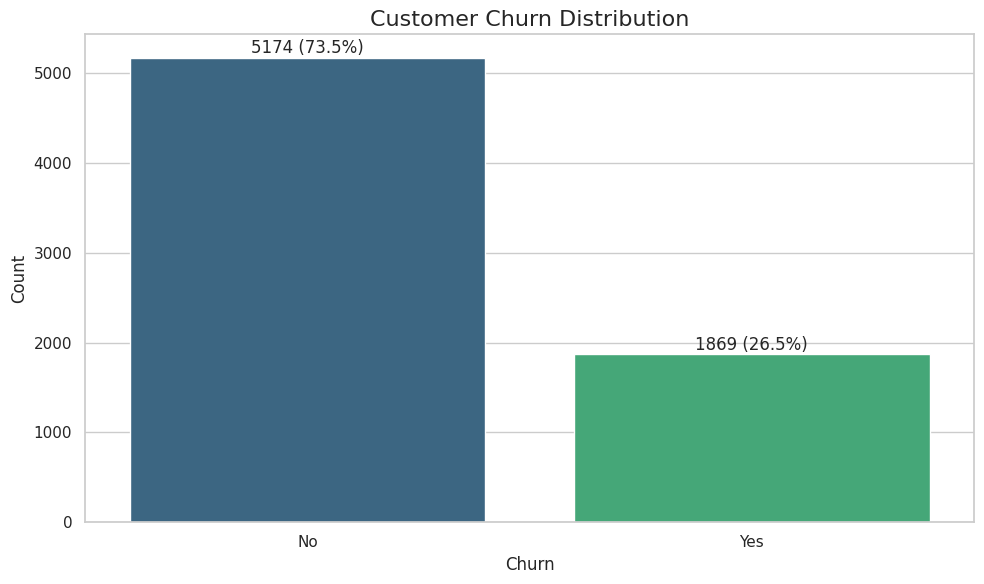

Churn Rate: 26.54%


In [ ]:
# Churn distribution
churn_counts = customer_data['Churn'].value_counts()
churn_percentage = churn_counts / len(customer_data) * 100

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Churn', data=customer_data, palette='viridis')
plt.title('Customer Churn Distribution', fontsize=16)
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count and percentage annotations
for i, (count, percentage) in enumerate(zip(churn_counts, churn_percentage)):
    ax.text(i, count + 50, f"{count} ({percentage:.1f}%)", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Churn Rate: {churn_percentage[1]:.2f}%")

Next, let's look at the distribution of categorical variables.

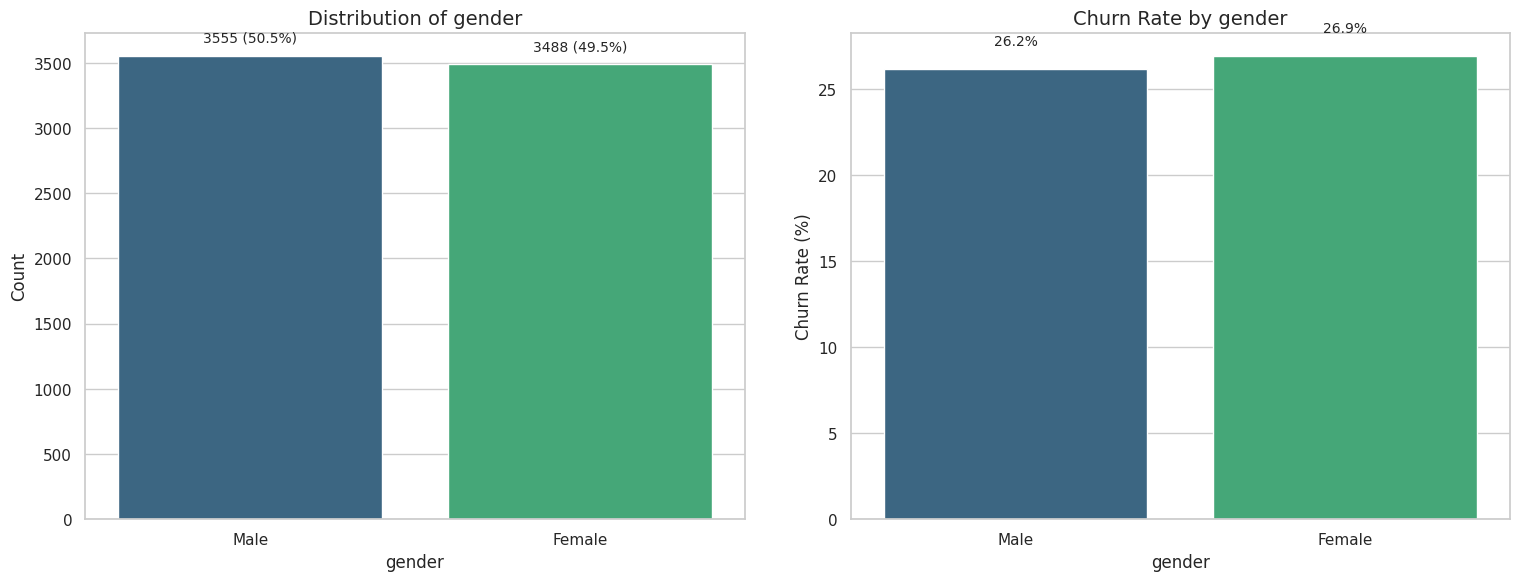

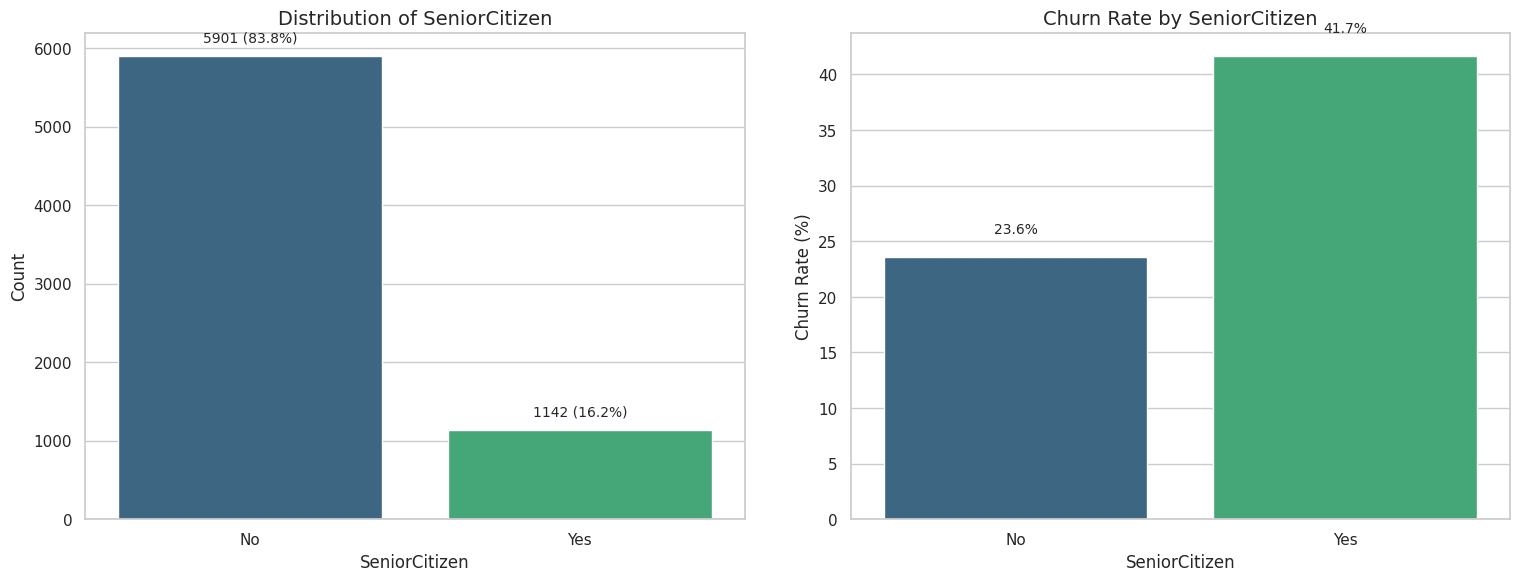

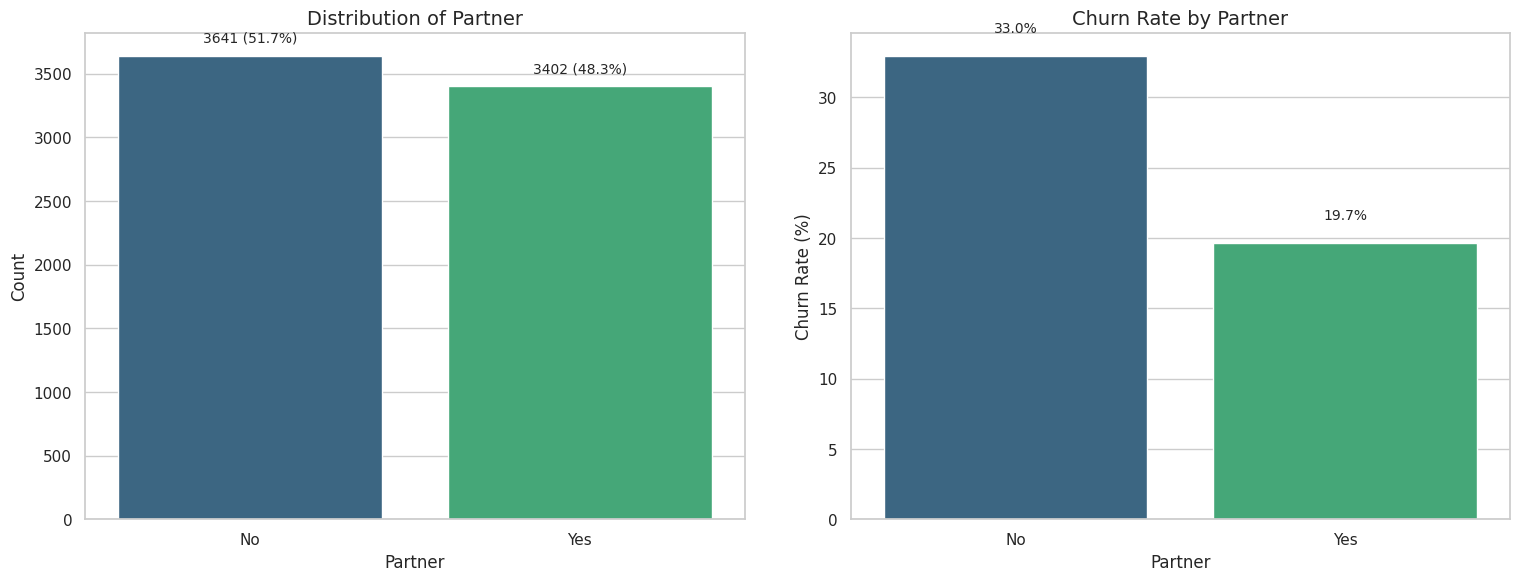

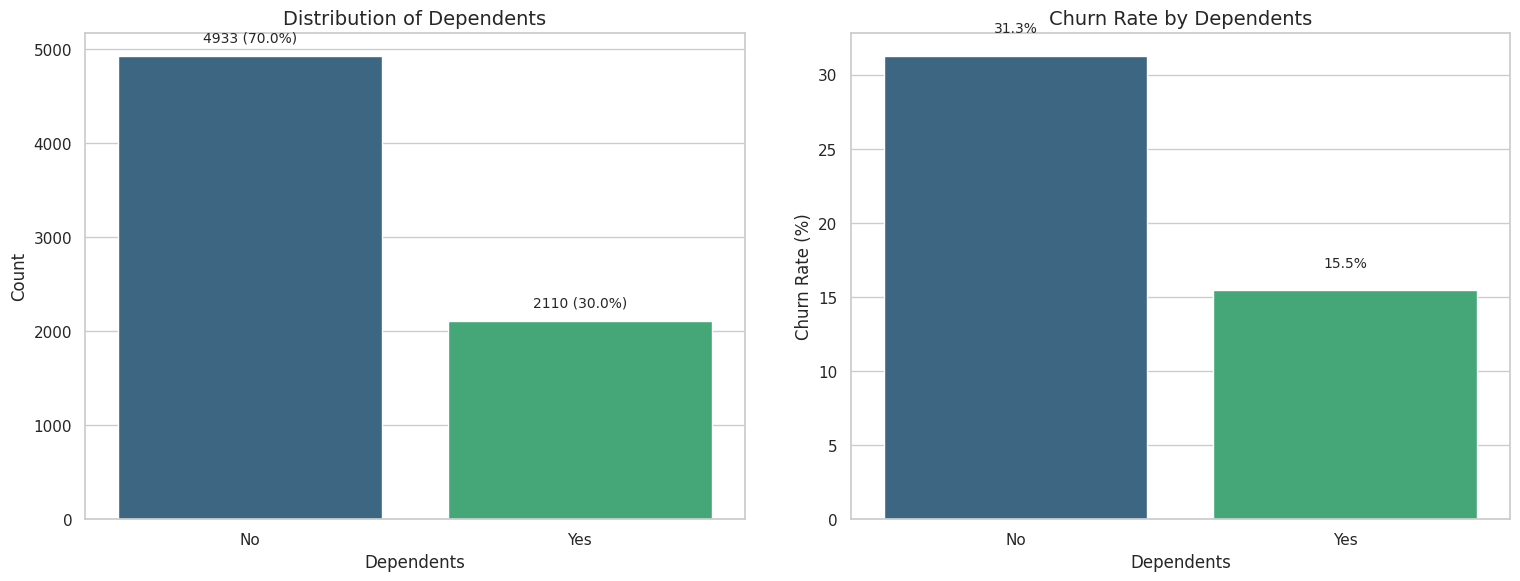

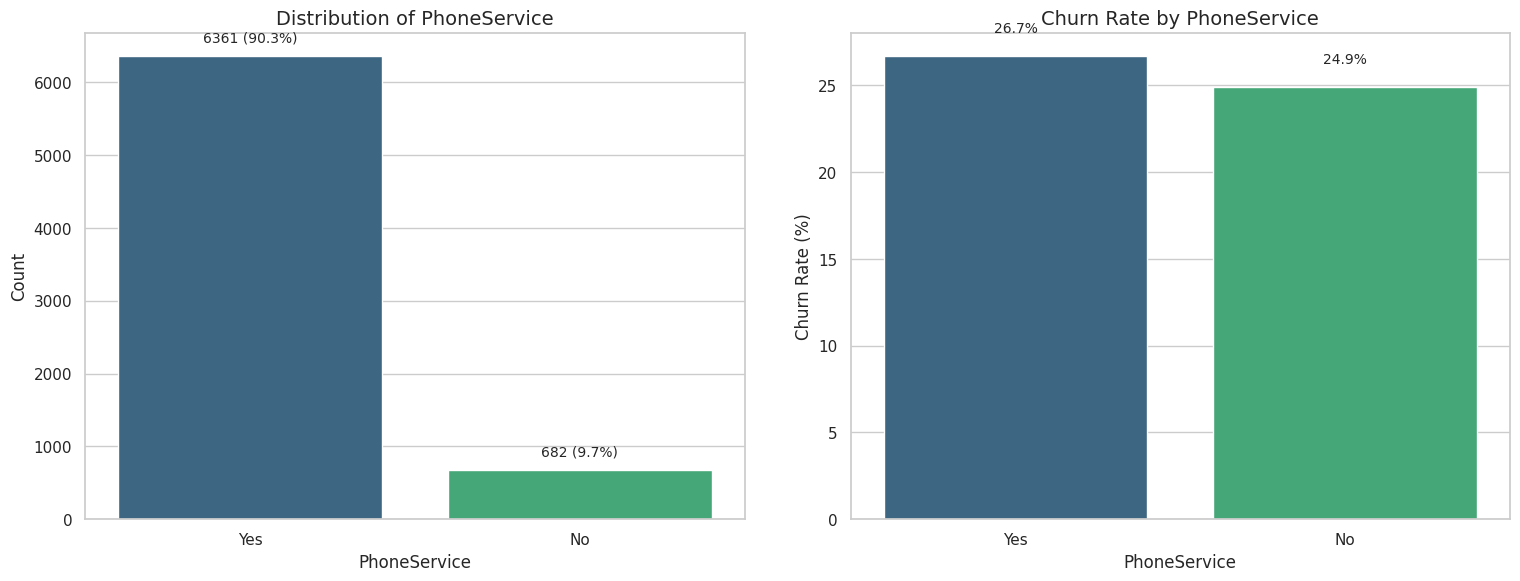

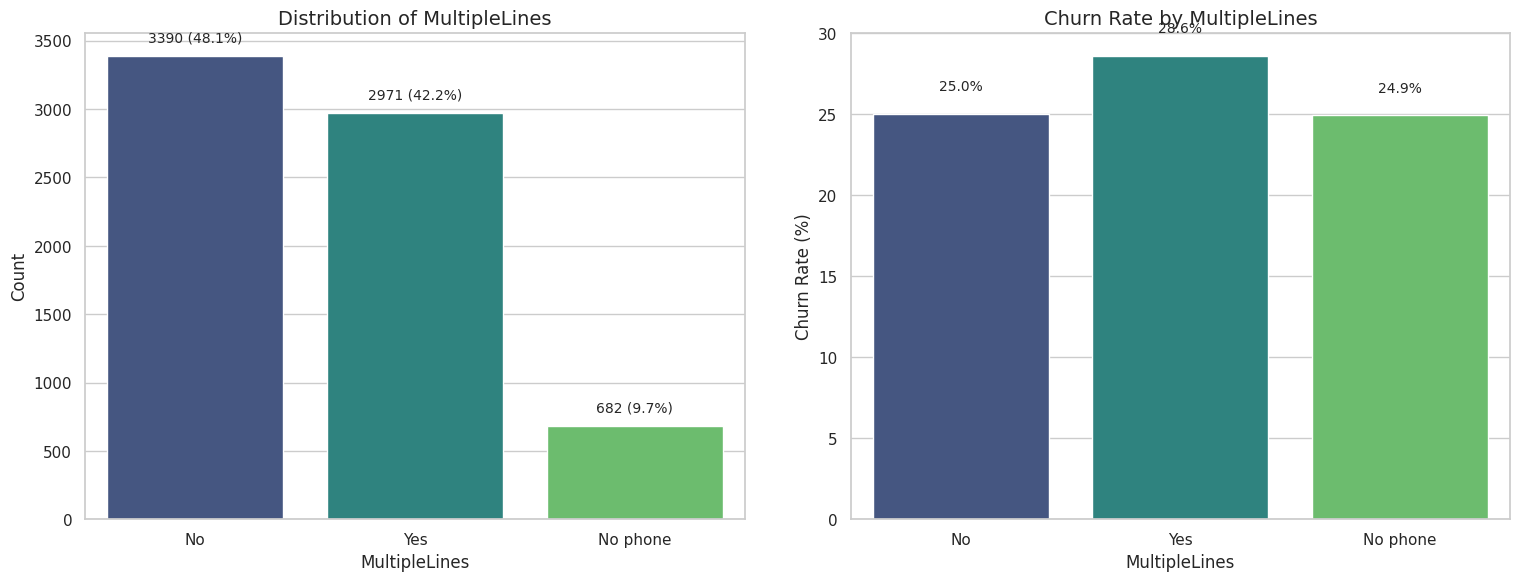

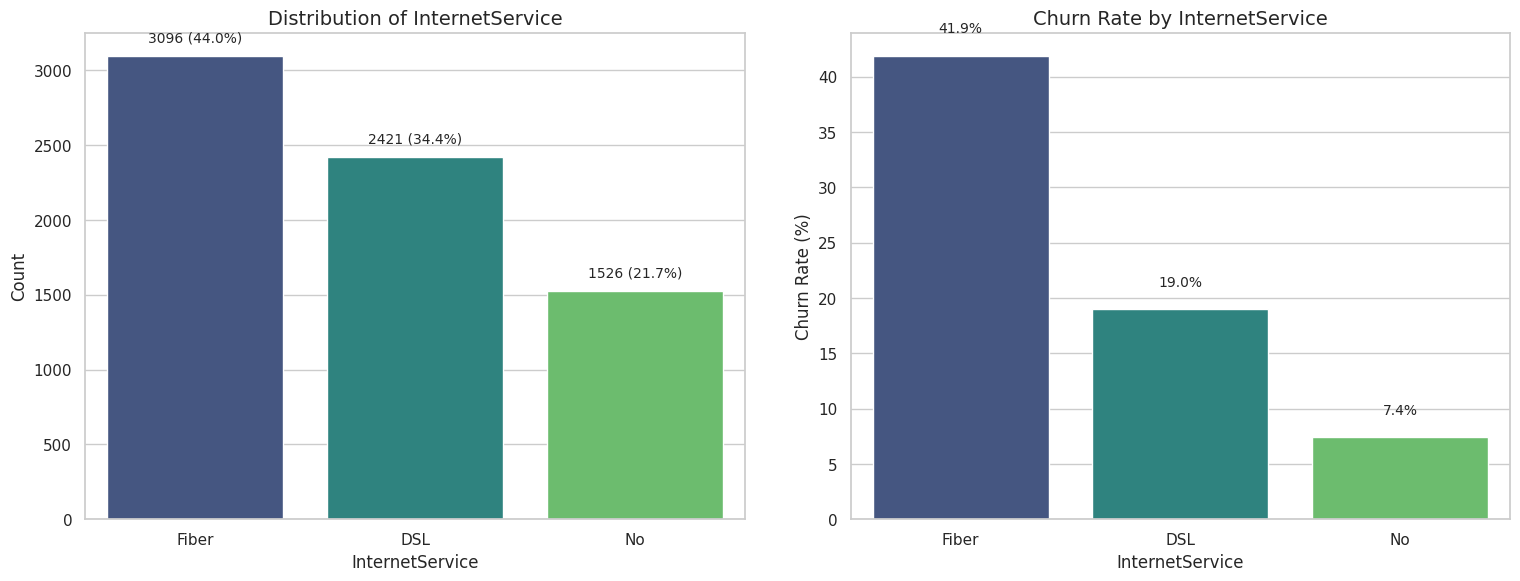

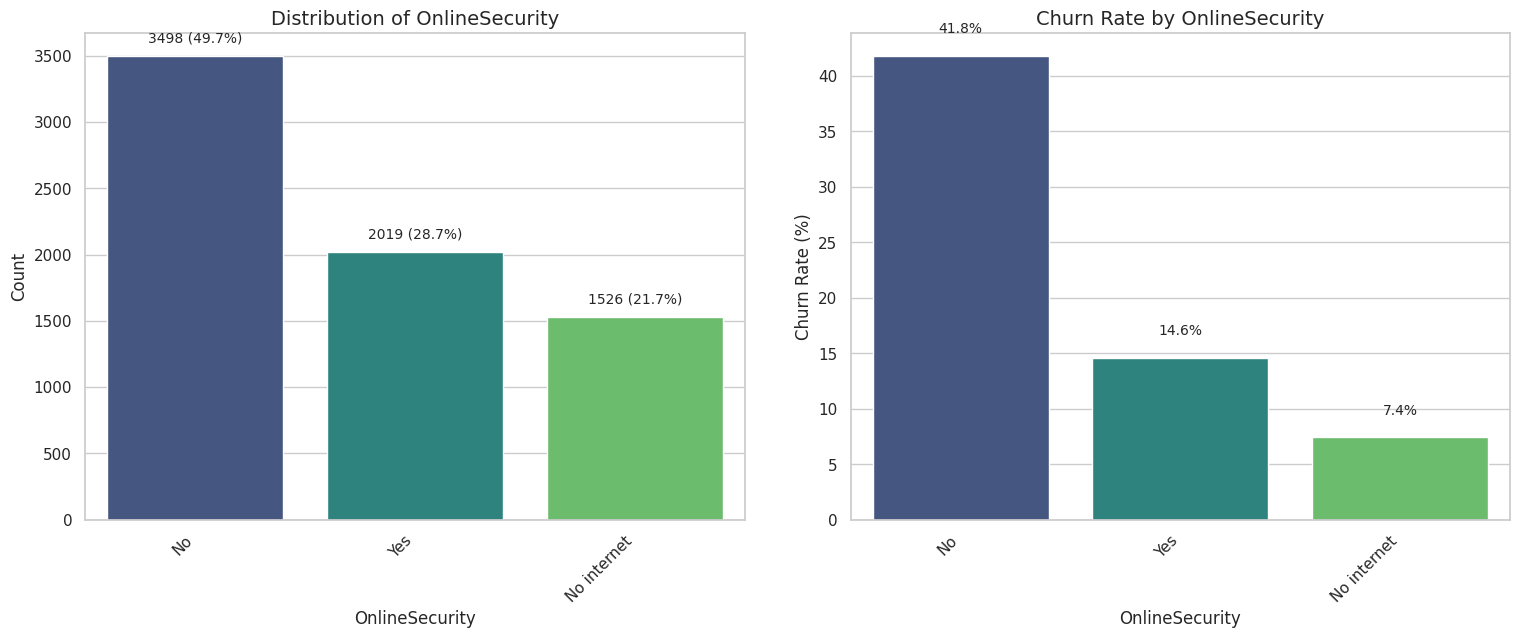

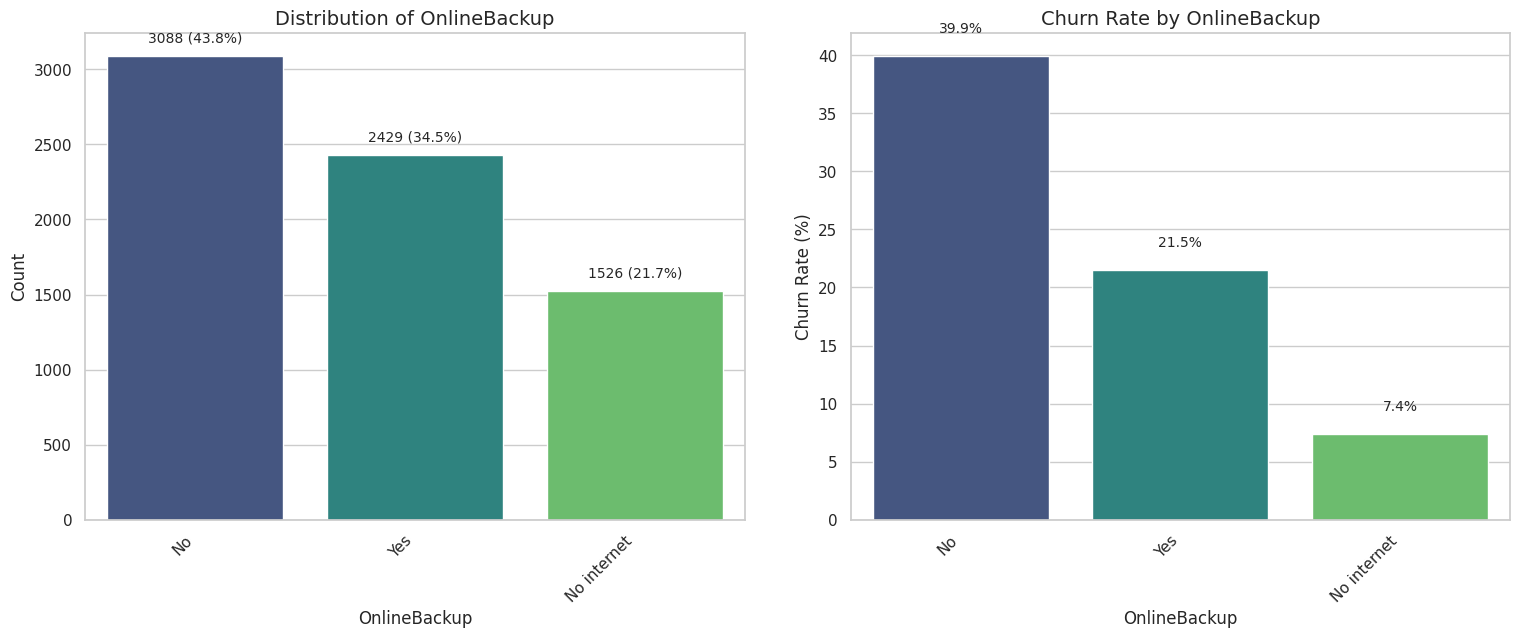

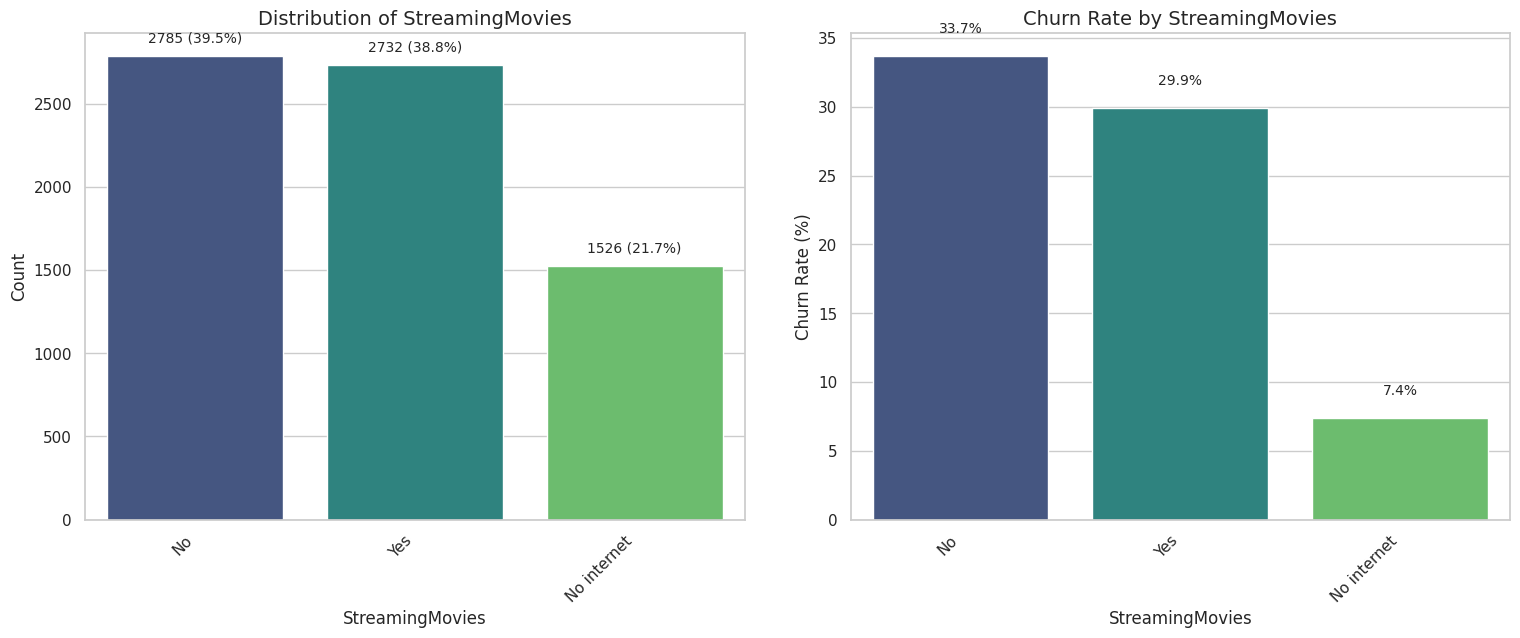

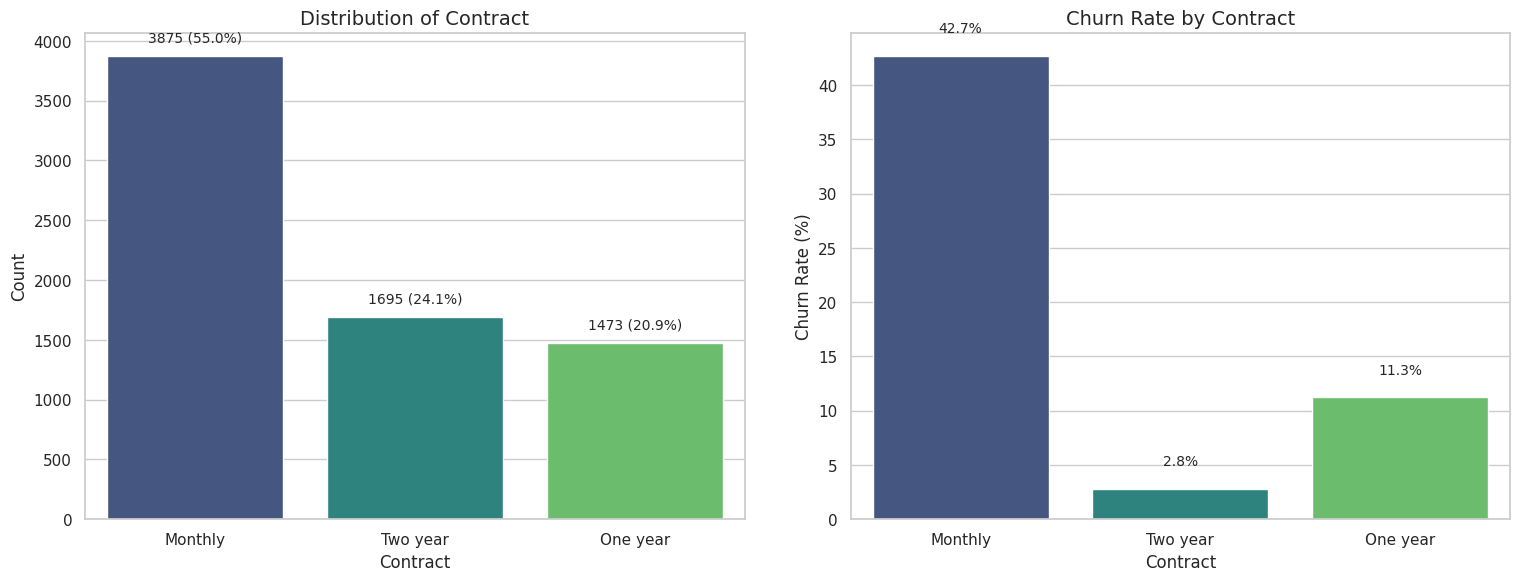

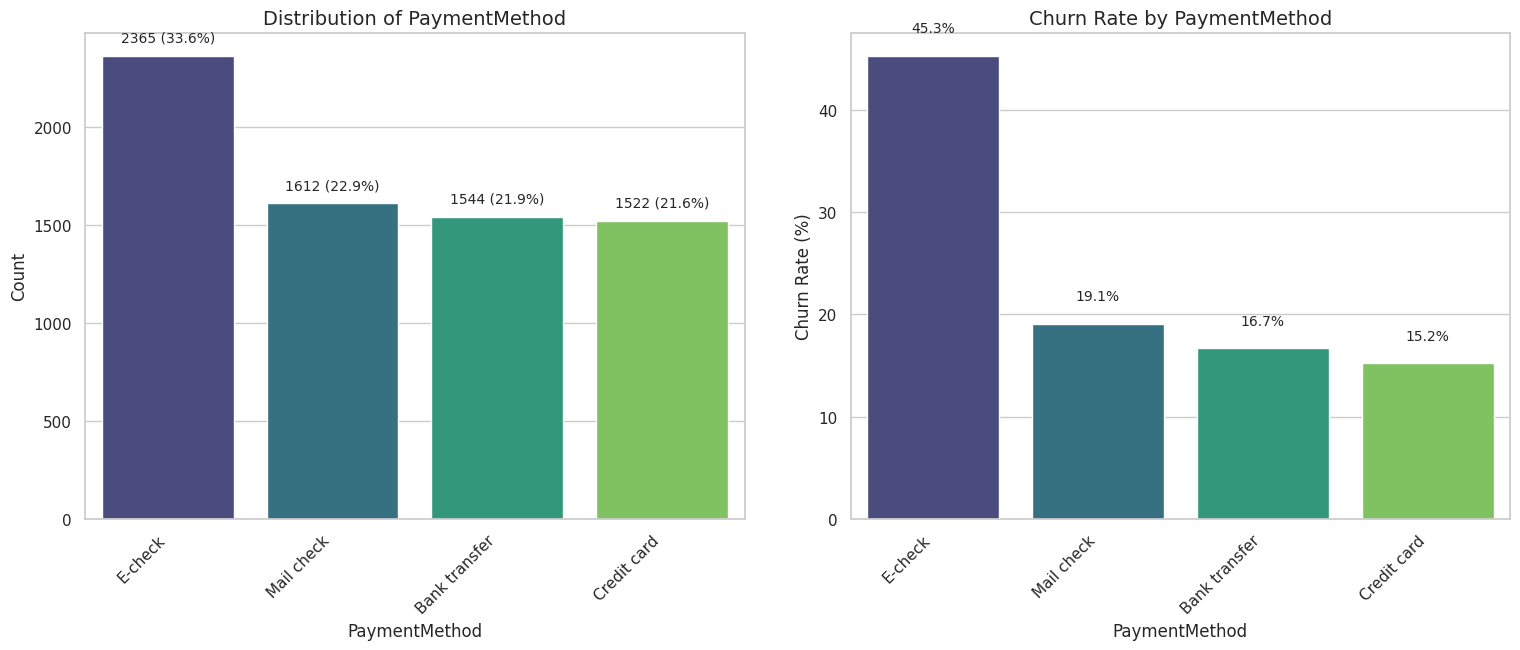

In [ ]:
def plot_categorical(df, column, figsize=(16, 7)):
    plt.figure(figsize=figsize)

    # Create a mapping for common long labels to make them more compact
    label_mapping = {
        'No internet service': 'No internet',
        'Bank transfer (automatic)': 'Bank transfer',
        'Credit card (automatic)': 'Credit card',
        'Electronic check': 'E-check',
        'Mailed check': 'Mail check',
        'Month-to-month': 'Monthly',
        'Fiber optic': 'Fiber',
        'No phone service': 'No phone'
    }

    # Create a temporary dataframe with shortened display labels
    temp_df = df.copy()
    if any(label in df[column].unique() for label in label_mapping.keys()):
        temp_df[column] = temp_df[column].replace(label_mapping)

    # Plot distribution
    plt.subplot(1, 2, 1)
    counts = temp_df[column].value_counts()

    # Create the countplot with shortened labels
    ax1 = sns.countplot(x=column, data=temp_df, order=counts.index, palette='viridis')

    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # Handle x-axis labels based on label length
    longest_label = max(len(str(x)) for x in temp_df[column].unique())
    if longest_label > 8:
        plt.xticks(rotation=45, ha='right')

    # Add count and percentage annotations
    total = len(df)
    for i, count in enumerate(counts):
        percentage = count / total * 100
        ax1.text(i, count + (max(counts) * 0.03), f"{count} ({percentage:.1f}%)",
                 ha='center', fontsize=10)

    # Plot churn rate by category
    plt.subplot(1, 2, 2)

    # Calculate churn rate using the same shortened labels
    churn_by_category = temp_df.groupby(column)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    churn_df = pd.DataFrame({
        column: churn_by_category.index,
        'Churn Rate (%)': churn_by_category.values
    })

    # Sort to match the order of the first plot
    churn_df = churn_df.set_index(column).loc[counts.index].reset_index()

    # Create the bar plot
    ax2 = sns.barplot(x=column, y='Churn Rate (%)', data=churn_df, palette='viridis')

    plt.title(f'Churn Rate by {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Churn Rate (%)', fontsize=12)

    # Use same rotation for consistency
    if longest_label > 8:
        plt.xticks(rotation=45, ha='right')

    # Add percentage annotations to the second plot
    y_max = churn_df['Churn Rate (%)'].max()
    for i, rate in enumerate(churn_df['Churn Rate (%)']):
        ax2.text(i, rate + (y_max * 0.05), f"{rate:.1f}%", ha='center', fontsize=10)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(bottom=0.2)

    plt.show()

# Plot key categorical variables
categorical_cols_to_plot = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

for col in categorical_cols_to_plot:
    plot_categorical(customer_data, col)

Now, let's look at the distribution of numerical variables.

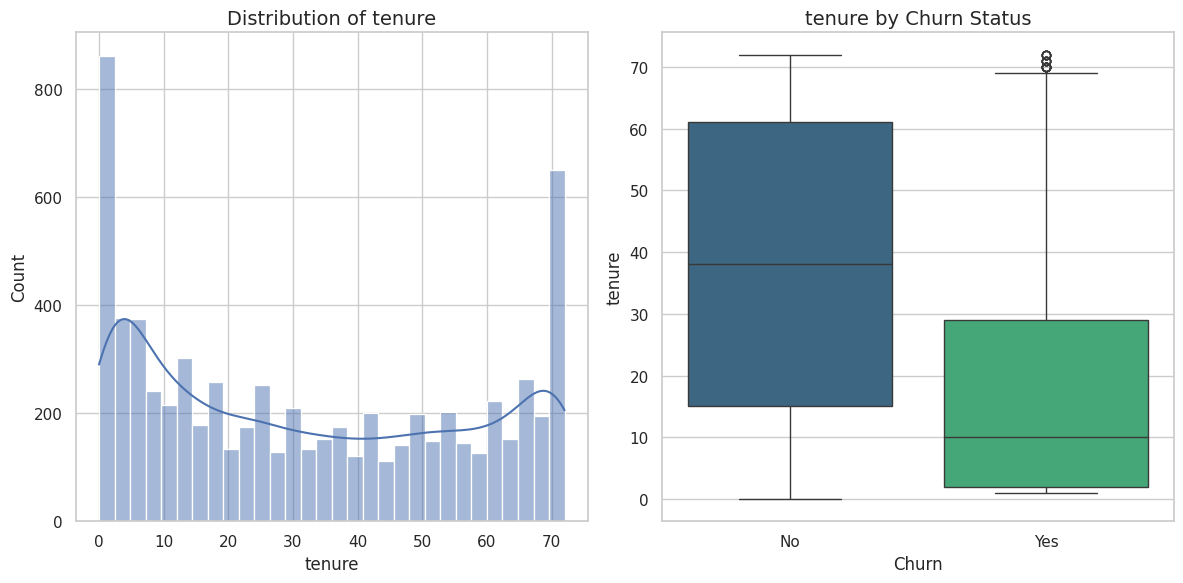

tenure statistics by churn status:
        mean  median  min  max
Churn                         
No     37.57    38.0    0   72
Yes    17.98    10.0    1   72




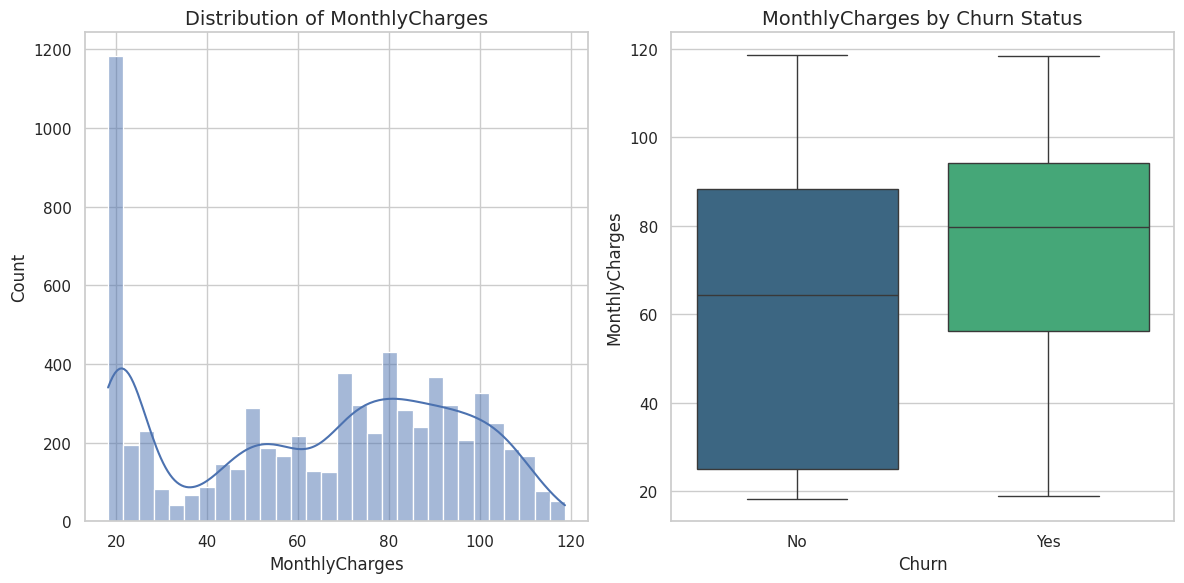

MonthlyCharges statistics by churn status:
        mean  median    min     max
Churn                              
No     61.27   64.43  18.25  118.75
Yes    74.44   79.65  18.85  118.35




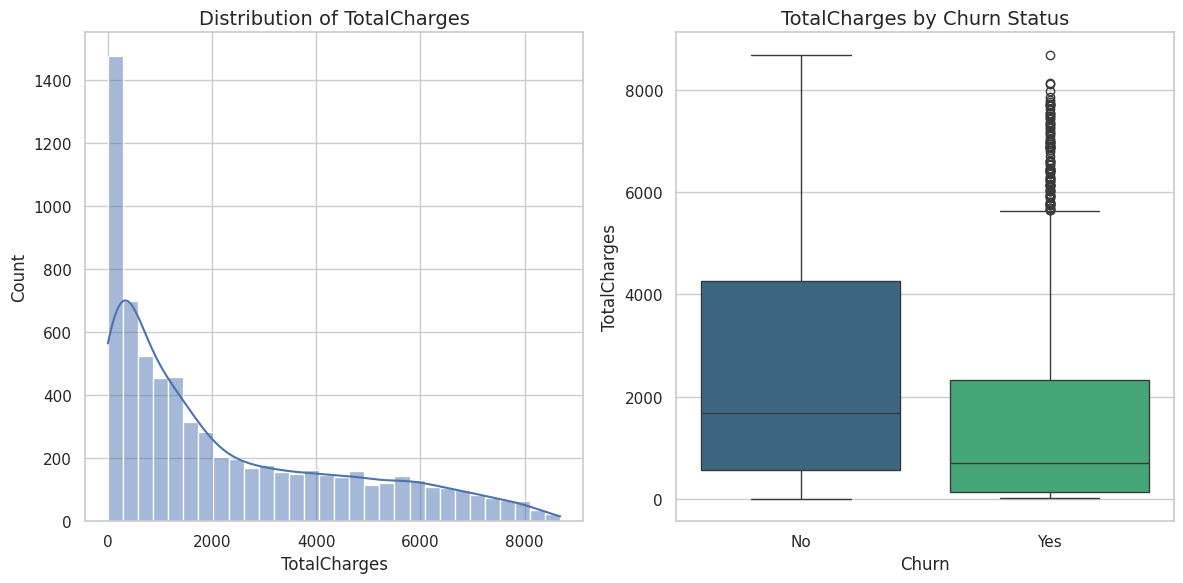

TotalCharges statistics by churn status:
          mean   median    min      max
Churn                                  
No     2549.91  1679.52   0.00  8672.45
Yes    1531.80   703.55  18.85  8684.80




In [ ]:
def preprocess_numeric_columns(df):
    # Make a copy to avoid modifying the original dataframe
    df_clean = df.copy()

    # Convert TotalCharges to numeric, handling spaces
    df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

    # Replace NaN values with 0 or another appropriate value
    # You might choose to use 0 (for new customers) or the mean/median depending on your analysis needs
    df_clean['TotalCharges'].fillna(0, inplace=True)

    return df_clean

# Function to plot numerical variables with improved handling
def plot_numerical(df, column, figsize=(12, 6)):
    plt.figure(figsize=figsize)

    # Plot distribution
    ax1 = plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=column, kde=True, bins=30)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # Plot boxplot by churn
    ax2 = plt.subplot(1, 2, 2)
    sns.boxplot(x='Churn', y=column, data=df, palette='viridis')
    plt.title(f'{column} by Churn Status', fontsize=14)
    plt.xlabel('Churn', fontsize=12)
    plt.ylabel(column, fontsize=12)

    plt.tight_layout()
    plt.show()

    # Print statistics by churn status
    stats = df.groupby('Churn')[column].agg(['mean', 'median', 'min', 'max']).round(2)
    print(f"{column} statistics by churn status:")
    print(stats)
    print("\n")

# Preprocess the data
customer_data_clean = preprocess_numeric_columns(customer_data)

# Plot numerical variables
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in numerical_cols:
    plot_numerical(customer_data_clean, col)

Let's create bins for continuous variables to better understand their relationship with churn.


tenure statistics by tenure_group:
              Mean  Median  Churn Rate (%)
tenure_group                              
0-12 months    4.8     4.0            47.7
13-24 months  18.4    18.0            28.7
25-36 months  30.3    30.0            21.6
37-48 months  42.6    43.0            19.0
49-60 months  54.5    54.0            14.4
61-72 months  68.1    69.0             6.6


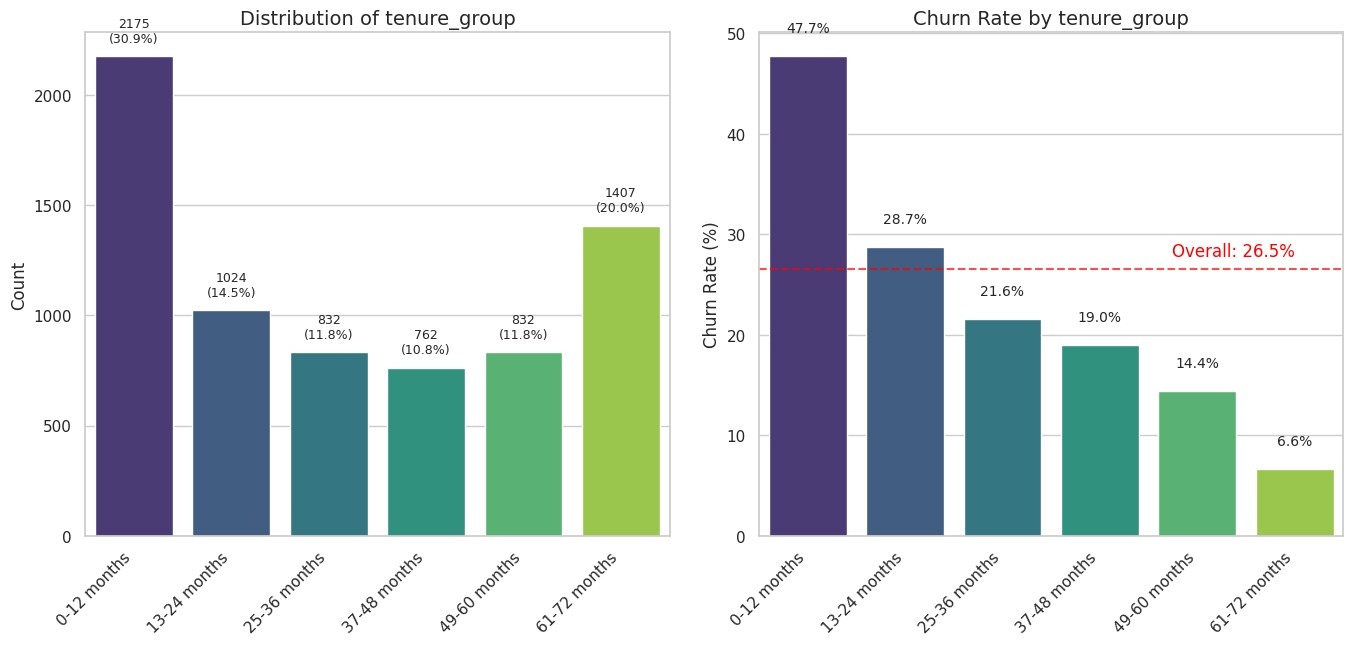


MonthlyCharges statistics by charges_group:
                Mean  Median  Churn Rate (%)
charges_group                               
$0-$30          21.5    20.2             9.8
$31-$50         42.8    44.6            30.8
$51-$70         60.0    59.8            20.8
$71-$90         80.1    80.0            37.8
$91+           101.0   100.2            32.8


In [ ]:
# Create tenure bins
customer_data['tenure_group'] = pd.cut(
    customer_data['tenure'],
    bins=[0, 12, 24, 36, 48, 60, 72],
    labels=['0-12 months', '13-24 months', '25-36 months', '37-48 months', '49-60 months', '61-72 months']
)

# Create monthly charges bins
customer_data['charges_group'] = pd.cut(
    customer_data['MonthlyCharges'],
    bins=[0, 30, 50, 70, 90, 120],
    labels=['$0-$30', '$31-$50', '$51-$70', '$71-$90', '$91+']
)

def plot_binned_variable(df, bin_column, original_column=None, figsize=(14, 7)):
    """
    Plot a binned variable showing both distribution and churn rate.

    Parameters:
    -----------
    df : DataFrame
        The DataFrame containing the data
    bin_column : str
        Name of the binned categorical column
    original_column : str, optional
        Name of the original continuous variable (for additional statistics)
    figsize : tuple, optional
        Figure size (width, height)
    """
    plt.figure(figsize=figsize)

    # Get ordered categories (bins)
    categories = df[bin_column].cat.categories

    # Calculate counts and percentages for each bin
    bin_counts = df[bin_column].value_counts().reindex(categories)
    bin_percentages = (bin_counts / len(df) * 100).round(1)

    # Calculate churn rate for each bin
    churn_by_bin = df.groupby(bin_column)['Churn'].apply(
        lambda x: (x == 'Yes').mean() * 100
    ).reindex(categories).round(1)

    # Plot distribution (left subplot)
    ax1 = plt.subplot(1, 2, 1)
    bars = sns.barplot(x=bin_counts.index, y=bin_counts.values, palette='viridis', ax=ax1)

    # Add count and percentage labels
    for i, (count, pct) in enumerate(zip(bin_counts, bin_percentages)):
        ax1.text(i, count + (max(bin_counts) * 0.03),
                f"{count}\n({pct}%)", ha='center', fontsize=9)

    plt.title(f'Distribution of {bin_column}', fontsize=14)
    plt.xlabel('')  # Remove x-label as it's redundant
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Plot churn rate (right subplot)
    ax2 = plt.subplot(1, 2, 2)
    bars = sns.barplot(x=churn_by_bin.index, y=churn_by_bin.values, palette='viridis', ax=ax2)

    # Add percentage labels
    for i, rate in enumerate(churn_by_bin):
        ax2.text(i, rate + (max(churn_by_bin) * 0.05),
                f"{rate}%", ha='center', fontsize=10)

    # Add reference line for overall churn rate
    overall_churn = (df['Churn'] == 'Yes').mean() * 100
    ax2.axhline(y=overall_churn, color='red', linestyle='--', alpha=0.7)
    ax2.text(len(categories)-1, overall_churn*1.05,
            f"Overall: {overall_churn:.1f}%", color='red', ha='right')

    plt.title(f'Churn Rate by {bin_column}', fontsize=14)
    plt.xlabel('')  # Remove x-label as it's redundant
    plt.ylabel('Churn Rate (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # If original column is provided, add statistics table
    if original_column:
        stats_table = df.groupby(bin_column)[original_column].agg(['mean', 'median']).round(1)
        stats_table.columns = ['Mean', 'Median']
        stats_table['Churn Rate (%)'] = churn_by_bin

        print(f"\n{original_column} statistics by {bin_column}:")
        print(stats_table)

    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(bottom=0.2)
    plt.show()

# Now plot the binned variables
plot_binned_variable(customer_data, 'tenure_group', 'tenure')
plot_binned_variable(customer_data, 'charges_group', 'MonthlyCharges')


### 4.2 Bivariate Analysis

Let's explore the relationships between different variables and their impact on churn.

In [ ]:
# Fix the TotalCharges column by converting to numeric
customer_data_clean = customer_data.copy()
customer_data_clean['TotalCharges'] = pd.to_numeric(customer_data_clean['TotalCharges'], errors='coerce')

# Fill NaN values with 0 (or you could use another strategy like mean imputation)
customer_data_clean['TotalCharges'].fillna(0, inplace=True)

# Now create the correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = customer_data_clean[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Variables', fontsize=16)
plt.tight_layout()
plt.show()


Service Count Distribution:
               Count  Percentage (%)  Churn Rate (%)
service_count                                       
1               1264            17.9            10.9
2                859            12.2            31.0
3                846            12.0            44.9
4                965            13.7            36.5
5                922            13.1            31.3
6                908            12.9            25.6
7                676             9.6            22.5
8                395             5.6            12.4
9                208             3.0             5.3

Correlation between service_count and churn: -0.019


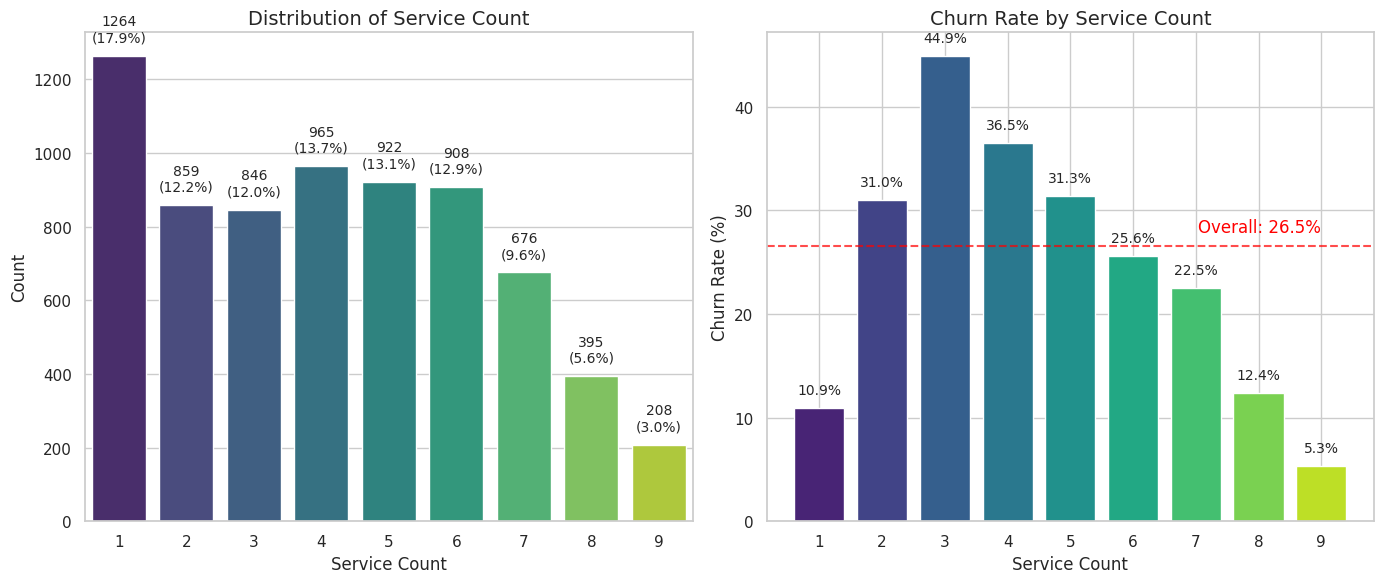

In [ ]:
# Service combinations analysis
# Create a count of services for each customer
service_columns = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                  'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Function to count active services
def count_services(row):
    count = 0
    if row['PhoneService'] == 'Yes':
        count += 1
        if row['MultipleLines'] == 'Yes':
            count += 1

    if row['InternetService'] != 'No':
        count += 1  # Count internet as one service
        # Count additional internet-related services
        for service in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies']:
            if row[service] == 'Yes':
                count += 1

    return count

# Apply the function
customer_data['service_count'] = customer_data.apply(count_services, axis=1)


def plot_count_variable(df, count_column, churn_column='Churn', figsize=(14, 6)):
    """
    Create a specialized visualization for count-based variables, showing both
    distribution and relationship with churn rate.

    Parameters:
    -----------
    df : DataFrame
        The DataFrame containing the data
    count_column : str
        Name of the count-based column (e.g., 'service_count')
    churn_column : str
        Name of the churn indicator column
    figsize : tuple
        Figure size (width, height)
    """
    plt.figure(figsize=figsize)

    # Get value counts and order properly
    value_counts = df[count_column].value_counts().sort_index()

    # Plot distribution (left subplot)
    ax1 = plt.subplot(1, 2, 1)
    sns.countplot(x=count_column, data=df, order=sorted(df[count_column].unique()),
                  palette='viridis', ax=ax1)

    # Add count and percentage annotations
    total = len(df)
    for i, count_value in enumerate(sorted(df[count_column].unique())):
        count = value_counts.get(count_value, 0)
        percentage = count / total * 100
        ax1.text(i, count + (max(value_counts) * 0.03),
                f"{count}\n({percentage:.1f}%)", ha='center', fontsize=10)

    plt.title(f'Distribution of {count_column.replace("_", " ").title()}', fontsize=14)
    plt.xlabel(count_column.replace("_", " ").title(), fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # Calculate churn rate by count value
    churn_by_count = df.groupby(count_column)[churn_column].apply(
        lambda x: (x == 'Yes').mean() * 100
    ).reindex(sorted(df[count_column].unique())).fillna(0)

    # Plot churn rate (right subplot)
    ax2 = plt.subplot(1, 2, 2)
    bars = ax2.bar(range(len(churn_by_count)), churn_by_count, color=sns.color_palette('viridis', len(churn_by_count)))

    # Set x-ticks to match the count values
    plt.xticks(range(len(churn_by_count)), sorted(df[count_column].unique()))

    # Add churn rate annotations
    for i, rate in enumerate(churn_by_count):
        ax2.text(i, rate + (max(churn_by_count) * 0.03),
                f"{rate:.1f}%", ha='center', fontsize=10)

    # Add reference line for overall churn rate
    overall_churn = (df[churn_column] == 'Yes').mean() * 100
    ax2.axhline(y=overall_churn, color='red', linestyle='--', alpha=0.7)
    ax2.text(len(churn_by_count)-1, overall_churn*1.05,
            f"Overall: {overall_churn:.1f}%", color='red', ha='right')

    plt.title(f'Churn Rate by {count_column.replace("_", " ").title()}', fontsize=14)
    plt.xlabel(count_column.replace("_", " ").title(), fontsize=12)
    plt.ylabel('Churn Rate (%)', fontsize=12)

    # Print summary statistics
    print(f"\nService Count Distribution:")
    count_distribution = pd.DataFrame({
        'Count': value_counts.values,
        'Percentage (%)': (value_counts / total * 100).round(1),
        'Churn Rate (%)': churn_by_count.round(1)
    }, index=value_counts.index)
    print(count_distribution)

    # Calculate correlation with churn
    churn_numeric = (df[churn_column] == 'Yes').astype(int)
    correlation = df[count_column].corr(churn_numeric)
    print(f"\nCorrelation between {count_column} and churn: {correlation:.3f}")

    plt.tight_layout()
    plt.show()

plot_count_variable(customer_data, 'service_count')

### 4.3 Multivariate Analysis

Let's look at the combined effect of multiple variables on churn.

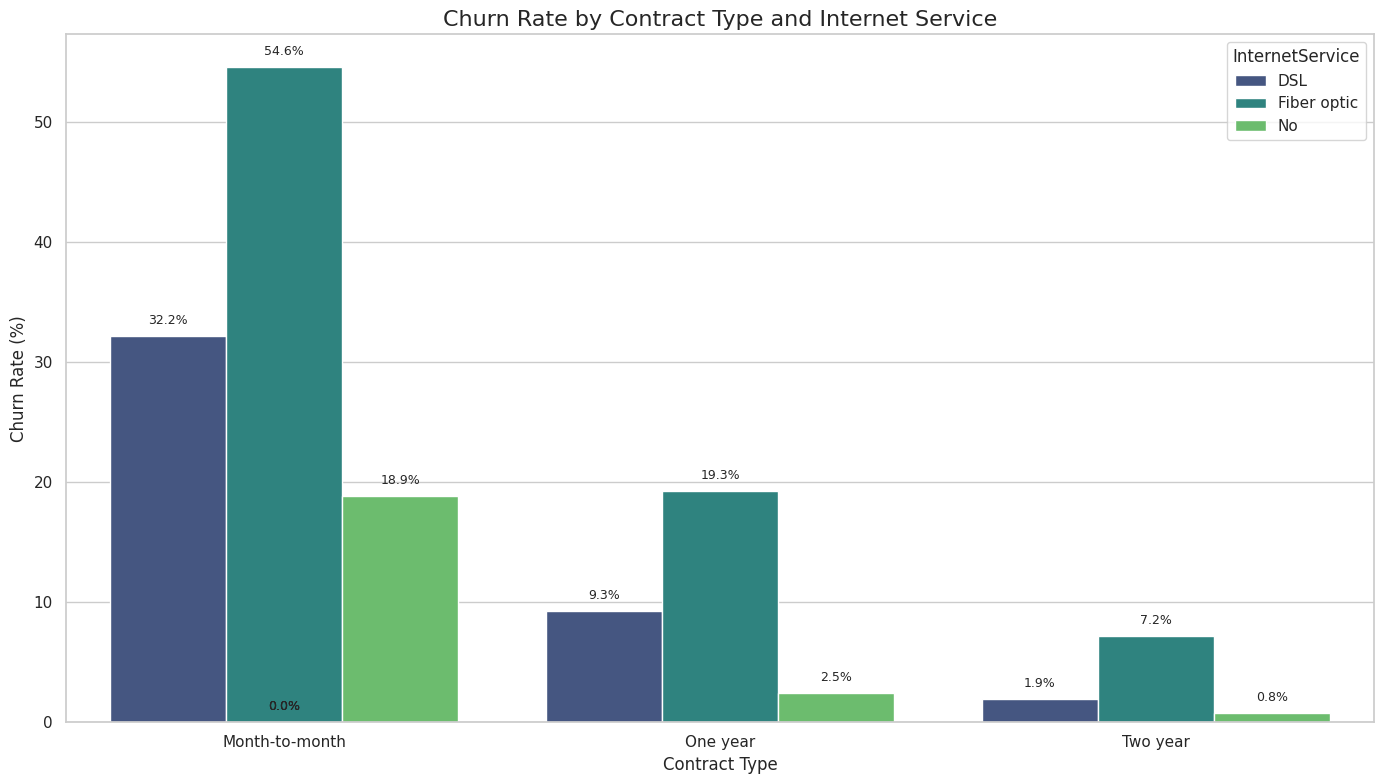

In [ ]:
# Contract type and internet service
plt.figure(figsize=(14, 8))
contract_internet_churn = customer_data.groupby(['Contract', 'InternetService'])['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100).reset_index()
contract_internet_churn.columns = ['Contract', 'InternetService', 'Churn Rate (%)']

ax = sns.barplot(x='Contract', y='Churn Rate (%)', hue='InternetService', data=contract_internet_churn, palette='viridis')
plt.title('Churn Rate by Contract Type and Internet Service', fontsize=16)
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

# Add percentage annotations
for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        f"{bar.get_height():.1f}%",
        ha='center', fontsize=9
    )

plt.tight_layout()
plt.show()

- 54.6% means that among customers with month-to-month contracts AND fiber optic internet, 54.6% of them left the company
- 0.8% means that among customers with two-year contracts AND no internet service, only 0.8% churned

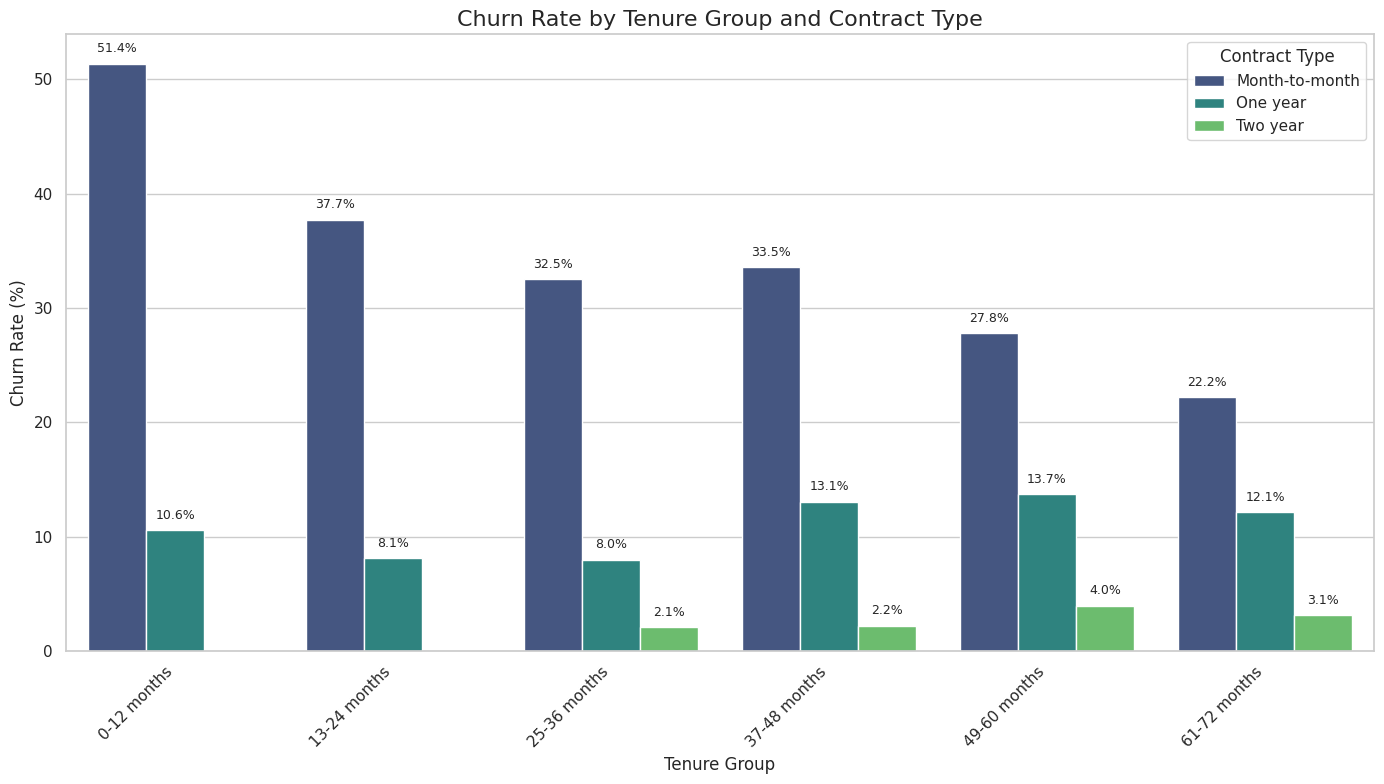

In [ ]:
# Tenure group and contract type
plt.figure(figsize=(14, 8))
tenure_contract_churn = customer_data.groupby(['tenure_group', 'Contract'])['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100).reset_index()
tenure_contract_churn.columns = ['Tenure Group', 'Contract', 'Churn Rate (%)']

ax = sns.barplot(x='Tenure Group', y='Churn Rate (%)', hue='Contract', data=tenure_contract_churn, palette='viridis')
plt.title('Churn Rate by Tenure Group and Contract Type', fontsize=16)
plt.xlabel('Tenure Group', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add percentage annotations
for i, bar in enumerate(ax.patches):
    if bar.get_height() > 0:  # Only annotate bars with values
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 1,
            f"{bar.get_height():.1f}%",
            ha='center', fontsize=9
        )

plt.tight_layout()
plt.legend(title='Contract Type')
plt.show()

### 4.4 High-Risk Customer Segment Analysis

Let's identify and analyze high-risk customer segments that have significantly higher churn rates.


In [ ]:
# Month-to-month contract + Fiber optic internet
monthly_fiber = customer_data[(customer_data['Contract'] == 'Month-to-month') &
                             (customer_data['InternetService'] == 'Fiber optic')]
monthly_fiber_churn_rate = (monthly_fiber['Churn'] == 'Yes').mean() * 100

# Month-to-month contract + Electronic check payment
monthly_electronic = customer_data[(customer_data['Contract'] == 'Month-to-month') &
                                  (customer_data['PaymentMethod'] == 'Electronic check')]
monthly_electronic_churn_rate = (monthly_electronic['Churn'] == 'Yes').mean() * 100

# New customers (0-12 months) with high charges
new_high_charges = customer_data[(customer_data['tenure'] <= 12) &
                                (customer_data['MonthlyCharges'] > 70)]
new_high_charges_churn_rate = (new_high_charges['Churn'] == 'Yes').mean() * 100

# Fiber optic without tech support
fiber_no_tech = customer_data[(customer_data['InternetService'] == 'Fiber optic') &
                             (customer_data['TechSupport'] == 'No')]
fiber_no_tech_churn_rate = (fiber_no_tech['Churn'] == 'Yes').mean() * 100

# Create a summary of high-risk segments
high_risk_segments = pd.DataFrame({
    'Segment': [
        'Month-to-month contract + Fiber optic internet',
        'Month-to-month contract + Electronic check payment',
        'New customers (0-12 months) with high charges (>$70)',
        'Fiber optic without tech support'
    ],
    'Total Customers': [
        len(monthly_fiber),
        len(monthly_electronic),
        len(new_high_charges),
        len(fiber_no_tech)
    ],
    'Churned Customers': [
        (monthly_fiber['Churn'] == 'Yes').sum(),
        (monthly_electronic['Churn'] == 'Yes').sum(),
        (new_high_charges['Churn'] == 'Yes').sum(),
        (fiber_no_tech['Churn'] == 'Yes').sum()
    ],
    'Churn Rate (%)': [
        monthly_fiber_churn_rate,
        monthly_electronic_churn_rate,
        new_high_charges_churn_rate,
        fiber_no_tech_churn_rate
    ]
})

high_risk_segments['Churn Rate (%)'] = high_risk_segments['Churn Rate (%)'].round(2)
high_risk_segments

Segment  Total Customers  \
0     Month-to-month contract + Fiber optic internet             2128   
1  Month-to-month contract + Electronic check pay...             1850   
2  New customers (0-12 months) with high charges ...              875   
3                   Fiber optic without tech support             2230   

   Churned Customers  Churn Rate (%)  
0               1162           54.61  
1                994           53.73  
2                594           67.89  
3               1101           49.37

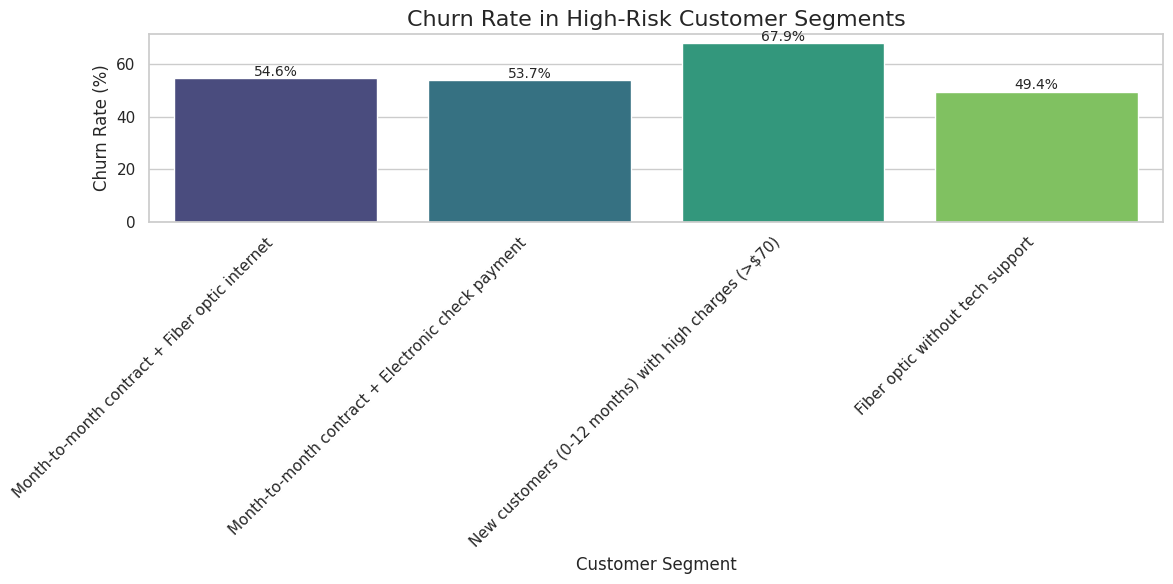

In [ ]:
# Visualize high-risk segments
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Segment', y='Churn Rate (%)', data=high_risk_segments, palette='viridis')
plt.title('Churn Rate in High-Risk Customer Segments', fontsize=16)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add percentage annotations
for i, rate in enumerate(high_risk_segments['Churn Rate (%)']):
    ax.text(i, rate + 1, f"{rate:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 5. Complaints Analysis

Let's analyze the unstructured customer complaints to extract additional insights.

In [ ]:
# Basic statistics on complaints
print(f"Total number of complaints: {len(complaints_data)}")
print(f"Number of unique customers with complaints: {complaints_data['customerID'].nunique()}")

# Merge complaints with customer data
complaints_with_churn = complaints_data.merge(
    customer_data[['customerID', 'Churn']],
    on='customerID',
    how='left'
)

# Calculate churn rate for customers with complaints
complaint_churn_rate = (complaints_with_churn['Churn'] == 'Yes').mean() * 100
print(f"Churn rate among customers with complaints: {complaint_churn_rate:.2f}%")

# Compare to overall churn rate
overall_churn_rate = (customer_data['Churn'] == 'Yes').mean() * 100
print(f"Overall churn rate: {overall_churn_rate:.2f}%")

Total number of complaints: 1605
Number of unique customers with complaints: 704
Churn rate among customers with complaints: 61.74%
Overall churn rate: 26.54%


Average number of complaints by churn status:
Churn
No     0.11867
Yes    0.53023
Name: complaint_count, dtype: float64


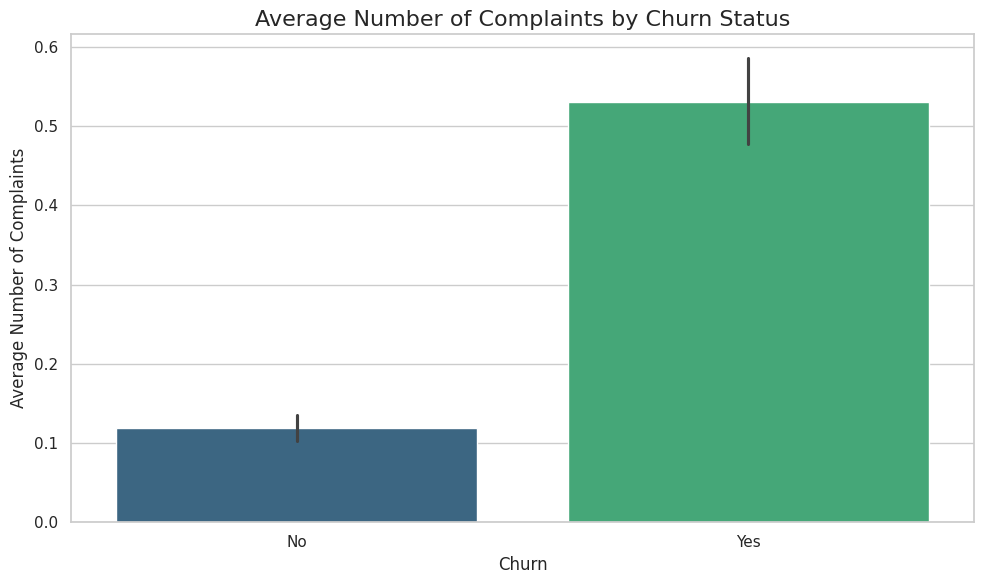

In [ ]:
# Count the number of complaints per customer
complaints_per_customer = complaints_data['customerID'].value_counts().reset_index()
complaints_per_customer.columns = ['customerID', 'complaint_count']

# Merge with customer data
customer_complaints = customer_data[['customerID', 'Churn']].merge(
    complaints_per_customer,
    on='customerID',
    how='left'
)

# Fill NaN values (customers with no complaints)
customer_complaints['complaint_count'] = customer_complaints['complaint_count'].fillna(0)

# Calculate average complaints by churn status
avg_complaints = customer_complaints.groupby('Churn')['complaint_count'].mean()
print("Average number of complaints by churn status:")
print(avg_complaints)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x='Churn', y='complaint_count', data=customer_complaints, palette='viridis', estimator=np.mean)
plt.title('Average Number of Complaints by Churn Status', fontsize=16)
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Average Number of Complaints', fontsize=12)
plt.tight_layout()
plt.show()

### 5.1 Text Analysis of Complaints

Let's perform text analysis on the complaint content to identify common themes and issues.


In [ ]:
import nltk
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize NLTK resources with explicit download
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Text preprocessing function
def preprocess_text(text):
    # Handle non-string or NaN values
    if pd.isna(text):
        return ""
    text = str(text)

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Simple tokenization as fallback if NLTK fails
    words = text.split()

    try:
        # NLTK tokenization if available
        tokens = word_tokenize(text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        return ' '.join(tokens)
    except LookupError:
        # Use the simple tokenization as fallback
        return ' '.join([w for w in words if w not in set(stopwords.words('english'))])

# Apply preprocessing to complaints
complaints_data['processed_complaint'] = complaints_data['complaint'].apply(preprocess_text)

# Create a term frequency-inverse document frequency (TF-IDF) vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(complaints_data['processed_complaint'])

# Get feature names and TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1

# Create a dataframe of terms and their scores
tfidf_df = pd.DataFrame({'term': feature_names, 'score': tfidf_scores})
tfidf_df = tfidf_df.sort_values('score', ascending=False).reset_index(drop=True)

# Display top terms
print("Top 20 terms in customer complaints by TF-IDF score:")
tfidf_df.head(20)

Top 20 terms in customer complaints by TF-IDF score:


term       score
0       service  152.012206
1      internet  130.502453
2       support  121.700434
3      customer  103.890226
4       despite  100.055564
5     streaming   98.418291
6      services   92.337777
7        issues   89.520696
8            im   88.426507
9          like   87.592552
10      monthly   85.025269
11      charges   81.194140
12       paying   79.830611
13         high   77.018540
14  frustrating   74.540242
15        issue   70.995175
16         tech   68.913911
17         feel   64.670716
18         lack   63.829185
19           tv   63.756962

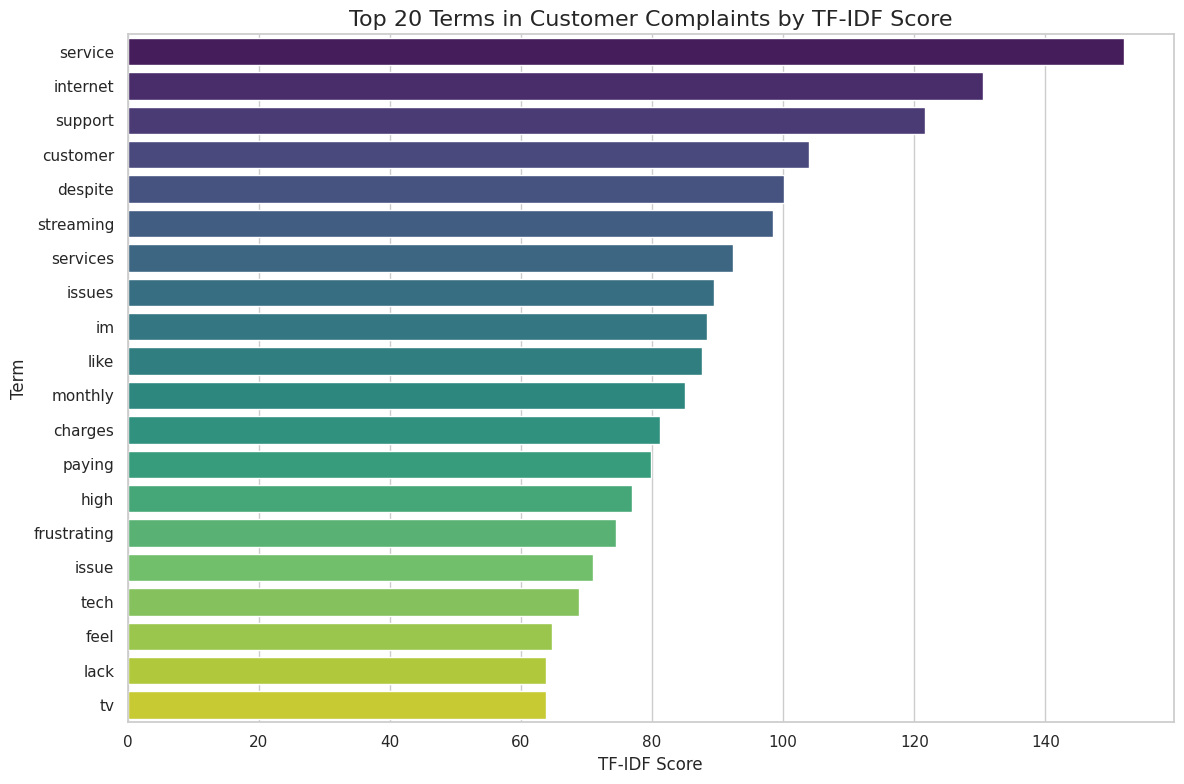

In [ ]:
# Visualize top terms
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='score', y='term', data=tfidf_df.head(20), palette='viridis')
plt.title('Top 20 Terms in Customer Complaints by TF-IDF Score', fontsize=16)
plt.xlabel('TF-IDF Score', fontsize=12)
plt.ylabel('Term', fontsize=12)
plt.tight_layout()
plt.show()

### 5.2 Topic Extraction

Let's identify key topics or themes in the complaints.

In [ ]:
# Define common issue categories and associated keywords
issue_categories = {
    'Internet Speed': ['slow', 'speed', 'fast', 'mbps', 'download', 'upload', 'bandwidth'],
    'Connection Issues': ['connection', 'disconnect', 'outage', 'down', 'dropped', 'unstable', 'intermittent'],
    'Billing Problems': ['bill', 'charge', 'overcharge', 'payment', 'price', 'expensive', 'cost', 'fee'],
    'Customer Service': ['service', 'representative', 'support', 'agent', 'call center', 'helpline', 'wait time'],
    'Technical Issues': ['technical', 'router', 'modem', 'device', 'equipment', 'installation', 'setup'],
    'Streaming Problems': ['streaming', 'buffer', 'freeze', 'video', 'tv', 'movie', 'show', 'quality'],
    'Contract Issues': ['contract', 'agreement', 'term', 'commitment', 'cancel', 'termination']
}

# Function to categorize complaints
def categorize_complaint(complaint_text):
    complaint_text = complaint_text.lower()
    categories = []

    for category, keywords in issue_categories.items():
        if any(keyword in complaint_text for keyword in keywords):
            categories.append(category)

    return categories if categories else ['Other']

# Apply categorization
complaints_data['issue_categories'] = complaints_data['complaint'].apply(categorize_complaint)

# Explode the categories list to get one row per category
exploded_categories = complaints_data.explode('issue_categories')

# Count occurrences of each category
category_counts = exploded_categories['issue_categories'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Calculate percentage
total = category_counts['Count'].sum()
category_counts['Percentage'] = (category_counts['Count'] / total * 100).round(2)

# Display the results
print("Distribution of complaint categories:")
category_counts

Distribution of complaint categories:


Category  Count  Percentage
0    Customer Service   1333       38.47
1    Billing Problems    637       18.38
2  Streaming Problems    629       18.15
3      Internet Speed    364       10.51
4   Connection Issues    276        7.97
5     Contract Issues    135        3.90
6    Technical Issues     72        2.08
7               Other     19        0.55

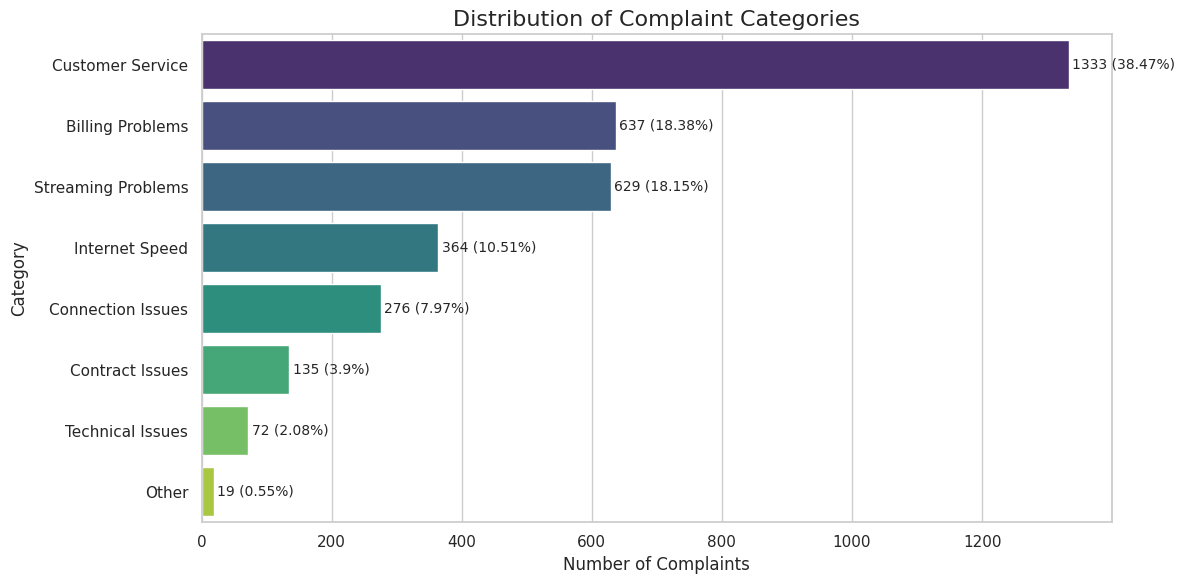

In [ ]:
# Visualize complaint categories
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Count', y='Category', data=category_counts, palette='viridis')
plt.title('Distribution of Complaint Categories', fontsize=16)
plt.xlabel('Number of Complaints', fontsize=12)
plt.ylabel('Category', fontsize=12)

# Add count and percentage annotations
for i, (count, percentage) in enumerate(zip(category_counts['Count'], category_counts['Percentage'])):
    ax.text(count + 5, i, f"{count} ({percentage}%)", va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 5.3 Complaint Analysis by Customer Segment

Let's examine if different customer segments have different types of complaints.


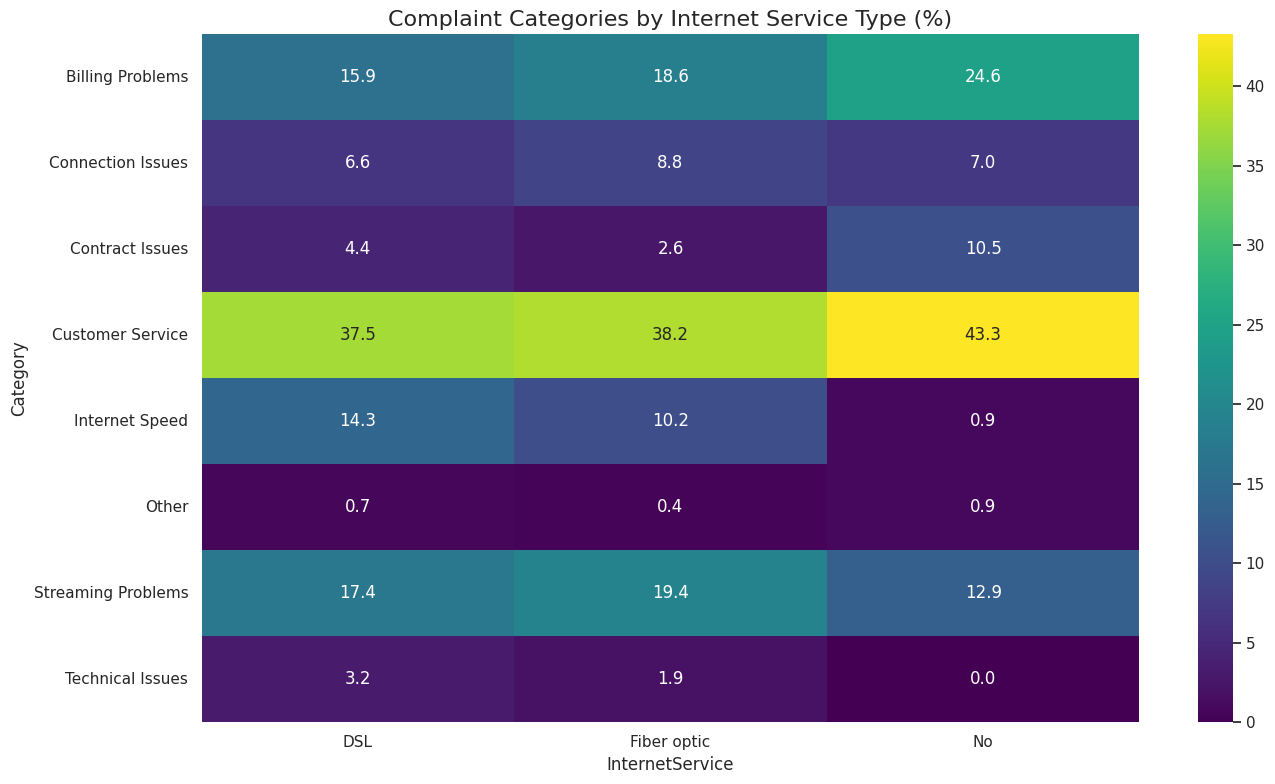

In [ ]:
# Merge complaints with customer segments
complaints_with_segments = complaints_data.merge(
    customer_data[['customerID', 'InternetService', 'Contract', 'tenure_group']],
    on='customerID',
    how='left'
)

# Explode the categories list to get one row per category
exploded_segments = complaints_with_segments.explode('issue_categories')

# Analyze complaints by internet service
internet_complaints = exploded_segments.groupby(['InternetService', 'issue_categories']).size().reset_index()
internet_complaints.columns = ['InternetService', 'Category', 'Count']

# Create pivot table
internet_pivot = internet_complaints.pivot_table(
    index='Category',
    columns='InternetService',
    values='Count',
    fill_value=0
)

# Calculate percentages within each internet service type
internet_pivot_pct = internet_pivot.div(internet_pivot.sum(axis=0), axis=1) * 100

# Visualize
plt.figure(figsize=(14, 8))
sns.heatmap(internet_pivot_pct, annot=True, cmap='viridis', fmt='.1f')
plt.title('Complaint Categories by Internet Service Type (%)', fontsize=16)
plt.tight_layout()
plt.show()

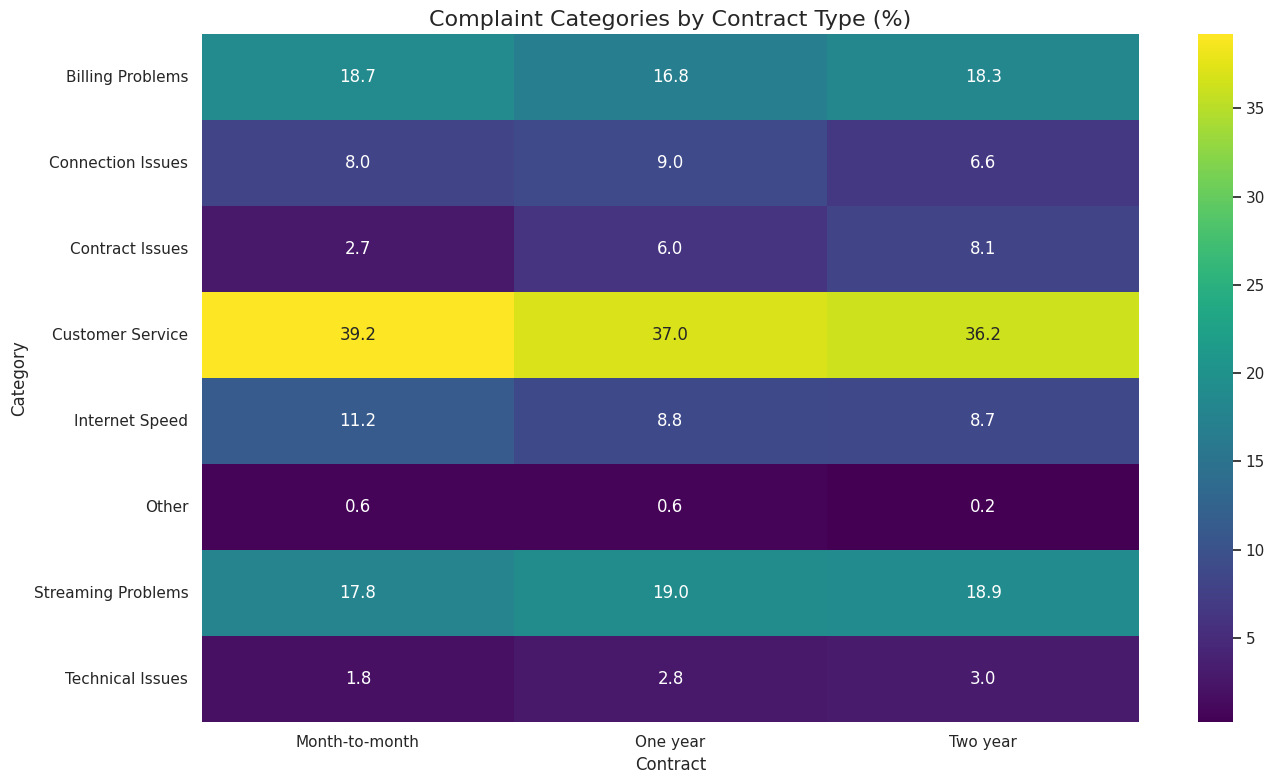

In [ ]:
# Analyze complaints by contract type
contract_complaints = exploded_segments.groupby(['Contract', 'issue_categories']).size().reset_index()
contract_complaints.columns = ['Contract', 'Category', 'Count']

# Create pivot table
contract_pivot = contract_complaints.pivot_table(
    index='Category',
    columns='Contract',
    values='Count',
    fill_value=0
)

# Calculate percentages within each contract type
contract_pivot_pct = contract_pivot.div(contract_pivot.sum(axis=0), axis=1) * 100

# Visualize
plt.figure(figsize=(14, 8))
sns.heatmap(contract_pivot_pct, annot=True, cmap='viridis', fmt='.1f')
plt.title('Complaint Categories by Contract Type (%)', fontsize=16)
plt.tight_layout()
plt.show()

## 6. Predictive Modeling

Now let's build a predictive model to identify customers at risk of churning.

### 6.1 Data Preparation

In [ ]:
print("Preparing data for modeling...")

# Check data types before conversion
print("\nData types before conversion:")
print(customer_data.dtypes.head())

# Check if TotalCharges has non-numeric values
print("\nSample of TotalCharges values:")
print(customer_data['TotalCharges'].head(10))

# Convert TotalCharges to numeric and handle missing values
customer_data['TotalCharges'] = pd.to_numeric(customer_data['TotalCharges'], errors='coerce')
customer_data['TotalCharges'].fillna(0, inplace=True)

# Check data types after conversion
print("\nData types after conversion:")
print(customer_data.dtypes.head())

# Select relevant features
# Note: We exclude columns we created during EDA and the target variable
X = customer_data.drop(['customerID', 'Churn', 'tenure_group', 'charges_group', 'service_count'], axis=1)
y = (customer_data['Churn'] == 'Yes').astype(int)  # Convert to binary (0/1)

# Display class distribution
print("\nClass distribution (Churn):")
print(y.value_counts())
print(f"Churn rate: {y.mean() * 100:.2f}%")

# Split data into training and testing sets
# We use stratified sampling to maintain the same churn rate in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Explicitly define categorical and numerical columns to avoid type issues
categorical_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Verify all columns are accounted for
all_cols = categorical_cols + numerical_cols
missing_cols = set(X.columns) - set(all_cols)
extra_cols = set(all_cols) - set(X.columns)

print("\nColumns check:")
print(f"Missing columns: {missing_cols}")
print(f"Extra columns: {extra_cols}")

Preparing data for modeling...

Data types before conversion:
customerID       object
gender           object
SeniorCitizen    object
Partner          object
Dependents       object
dtype: object

Sample of TotalCharges values:
0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
5      820.5
6     1949.4
7      301.9
8    3046.05
9    3487.95
Name: TotalCharges, dtype: object

Data types after conversion:
customerID       object
gender           object
SeniorCitizen    object
Partner          object
Dependents       object
dtype: object

Class distribution (Churn):
Churn
0    5174
1    1869
Name: count, dtype: int64
Churn rate: 26.54%

Training set size: 5634 samples
Testing set size: 1409 samples

Columns check:
Missing columns: set()
Extra columns: set()


The stratify=y parameter ensures that both your training and test sets have the same proportion of churned customers as in the original dataset. This is crucial because:

Churn datasets are typically imbalanced - Usually only a small percentage of customers churn (often 10-30%)
Without stratification, random sampling might create:

A training set with too few churned customers, making it hard for the model to learn the patterns of churn
A test set with a different churn rate than reality, leading to misleading performance metrics

### 6.2 Feature Engineering and Preprocessing Pipeline


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\nSetting up preprocessing pipeline...")

# Create preprocessor
# This handles both categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    verbose_feature_names_out=False  # Avoid long feature names
)

# Create pipelines for different models
# Combining preprocessing and model training in a single pipeline
# This ensures that the same preprocessing is applied to training and testing data
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,     # Number of trees
        max_depth=10,         # Maximum tree depth
        min_samples_split=5,  # Minimum samples required to split
        random_state=42       # For reproducibility
    ))
])

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=100,     # Number of boosting stages
        learning_rate=0.1,    # Shrinkage learning rate
        max_depth=5,          # Maximum tree depth
        random_state=42       # For reproducibility
    ))
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=100,     # Number of boosting rounds
        max_depth=5,          # Maximum tree depth
        learning_rate=0.1,    # Learning rate
        objective='binary:logistic',  # For binary classification
        random_state=42       # For reproducibility
    ))
])


Setting up preprocessing pipeline...


### 6.3 Model Training
We'll train three different models and compare their performance


In [ ]:
print("\nTraining Random Forest model...")
rf_pipeline.fit(X_train, y_train)

print("Training Gradient Boosting model...")
gb_pipeline.fit(X_train, y_train)

print("Training XGBoost model...")
xgb_pipeline.fit(X_train, y_train)



Training Random Forest model...
Training Gradient Boosting model...
Training XGBoost model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSuppo...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

### 6.4 Model Evaluation
We'll evaluate each model on the test set


Random Forest Performance:
Accuracy: 0.8062
Precision: 0.6689
Recall: 0.5348
F1 Score: 0.5944
ROC AUC: 0.8421

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



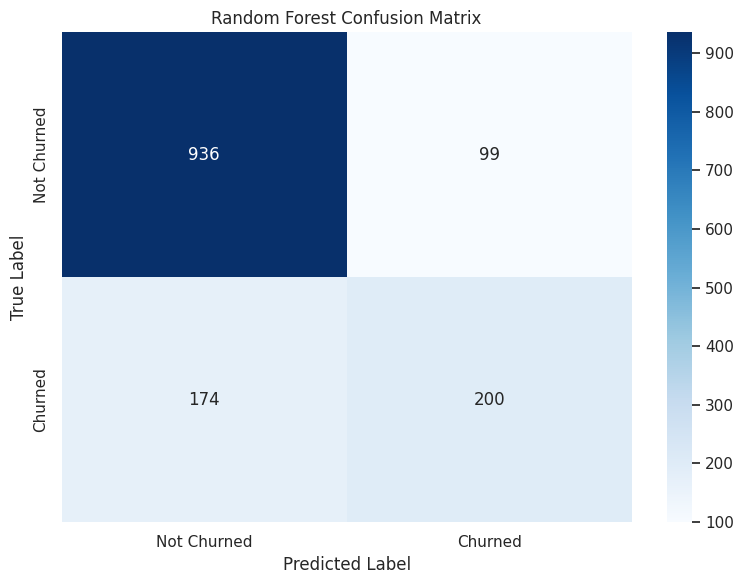

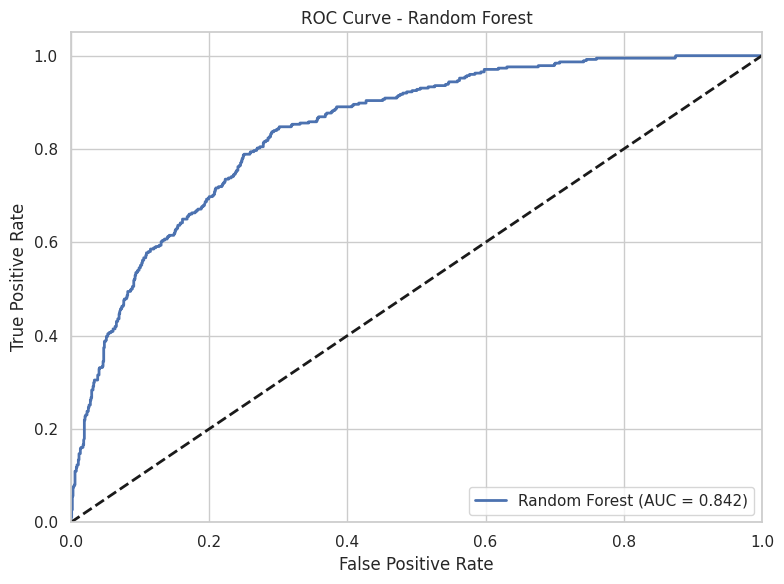


Gradient Boosting Performance:
Accuracy: 0.7935
Precision: 0.6269
Recall: 0.5481
F1 Score: 0.5849
ROC AUC: 0.8365

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.63      0.55      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.72      0.72      1409
weighted avg       0.79      0.79      0.79      1409



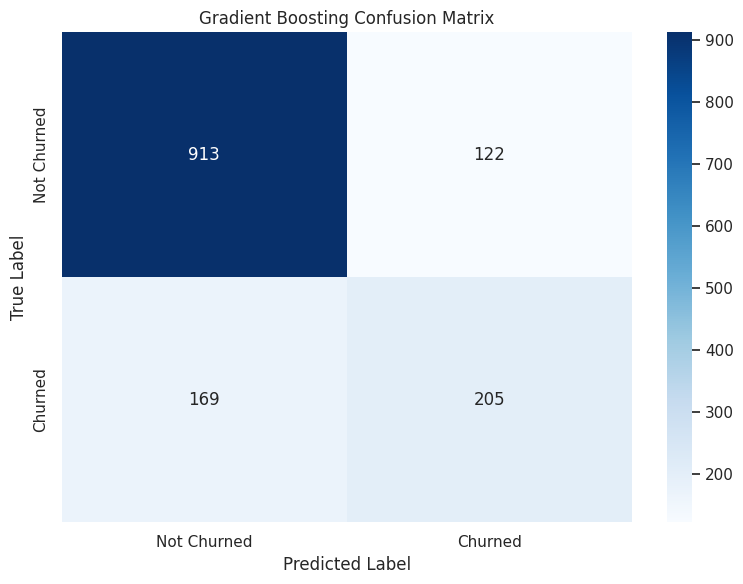

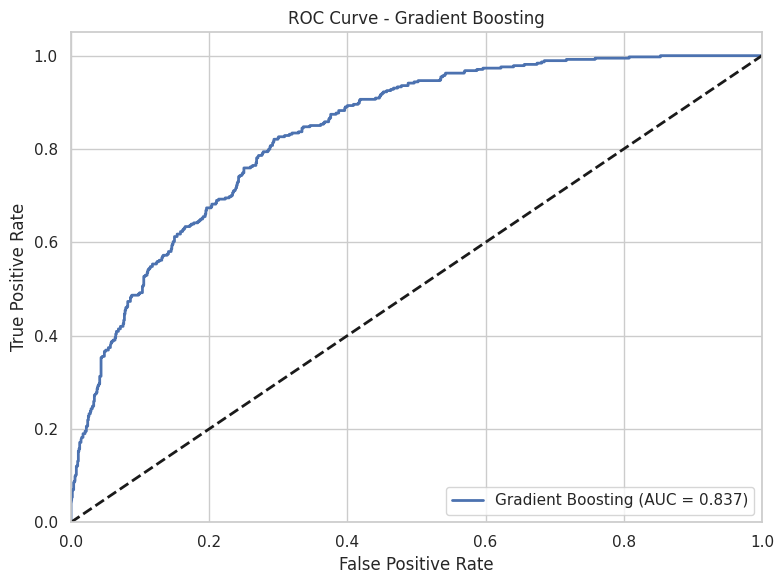


XGBoost Performance:
Accuracy: 0.7977
Precision: 0.6459
Recall: 0.5267
F1 Score: 0.5803
ROC AUC: 0.8424

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



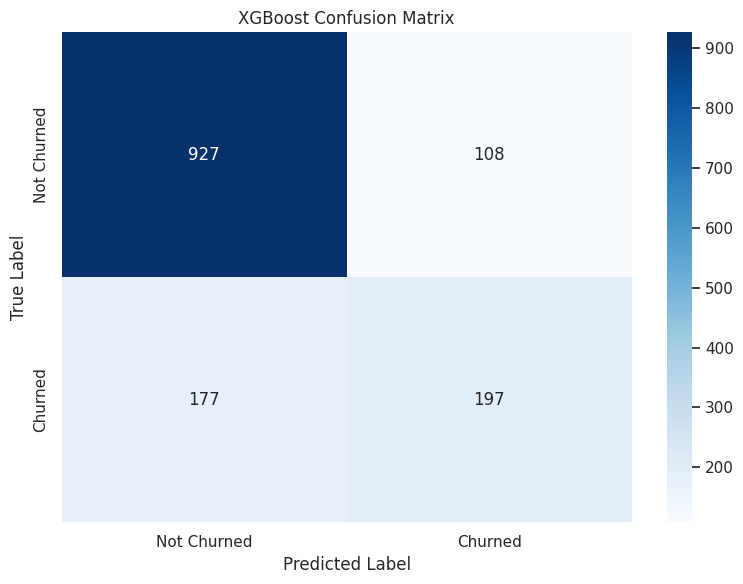

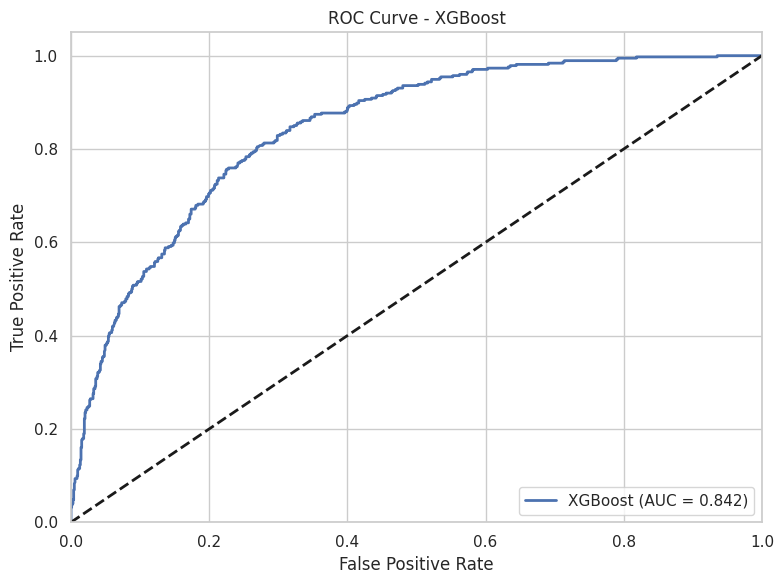


Model Comparison:
           Random Forest  Gradient Boosting   XGBoost
Accuracy        0.806246           0.793471  0.797729
Precision       0.668896           0.626911  0.645902
Recall          0.534759           0.548128  0.526738
F1 Score        0.594354           0.584879  0.580265
ROC AUC         0.842068           0.836502  0.842438


<Figure size 1200x800 with 0 Axes>

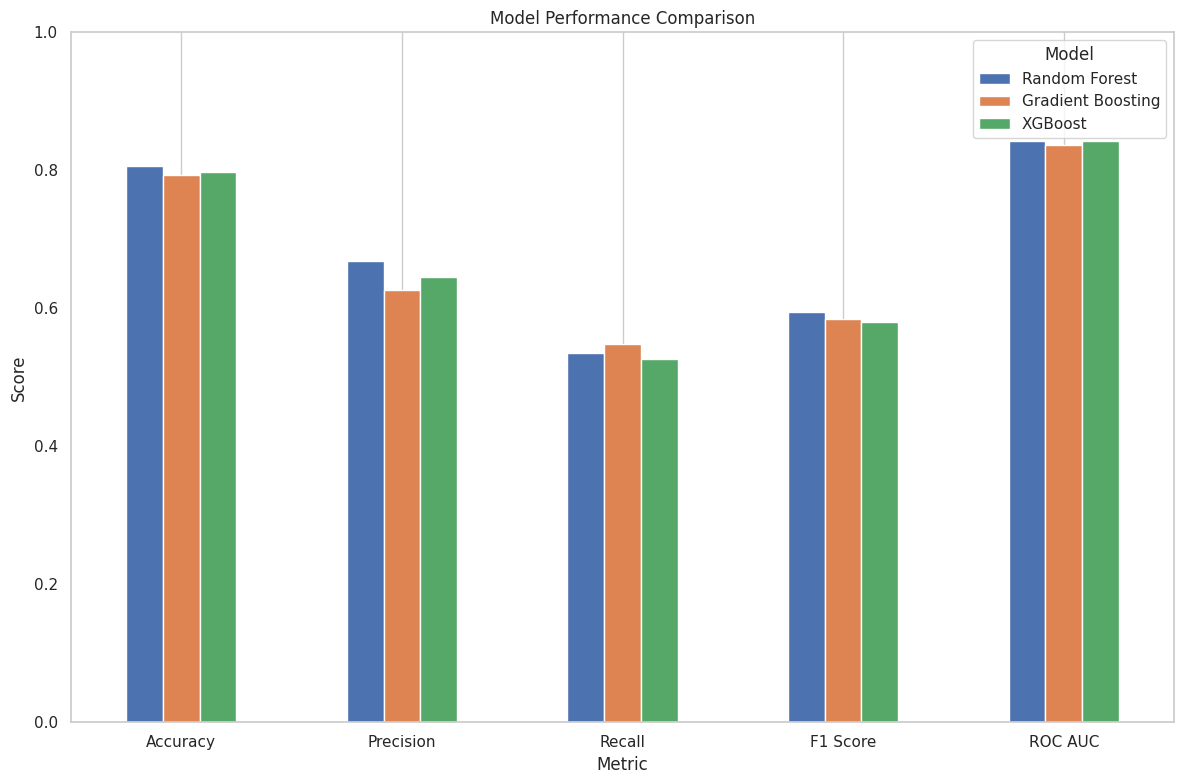

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate model performance with multiple metrics
    """
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print metrics
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churned', 'Churned'],
                yticklabels=['Not Churned', 'Churned'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Evaluate all models
rf_results = evaluate_model(rf_pipeline, X_test, y_test, 'Random Forest')
gb_results = evaluate_model(gb_pipeline, X_test, y_test, 'Gradient Boosting')
xgb_results = evaluate_model(xgb_pipeline, X_test, y_test, 'XGBoost')

# Compare model performance
models_comparison = pd.DataFrame({
    'Random Forest': [rf_results['accuracy'], rf_results['precision'],
                      rf_results['recall'], rf_results['f1'], rf_results['roc_auc']],
    'Gradient Boosting': [gb_results['accuracy'], gb_results['precision'],
                          gb_results['recall'], gb_results['f1'], gb_results['roc_auc']],
    'XGBoost': [xgb_results['accuracy'], xgb_results['precision'],
                xgb_results['recall'], xgb_results['f1'], xgb_results['roc_auc']]
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

print("\nModel Comparison:")
print(models_comparison)

# Plot model comparison
plt.figure(figsize=(12, 8))
models_comparison.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


# 6.5 Feature Importance Analysis


Analyzing feature importance for the best model: XGBoost


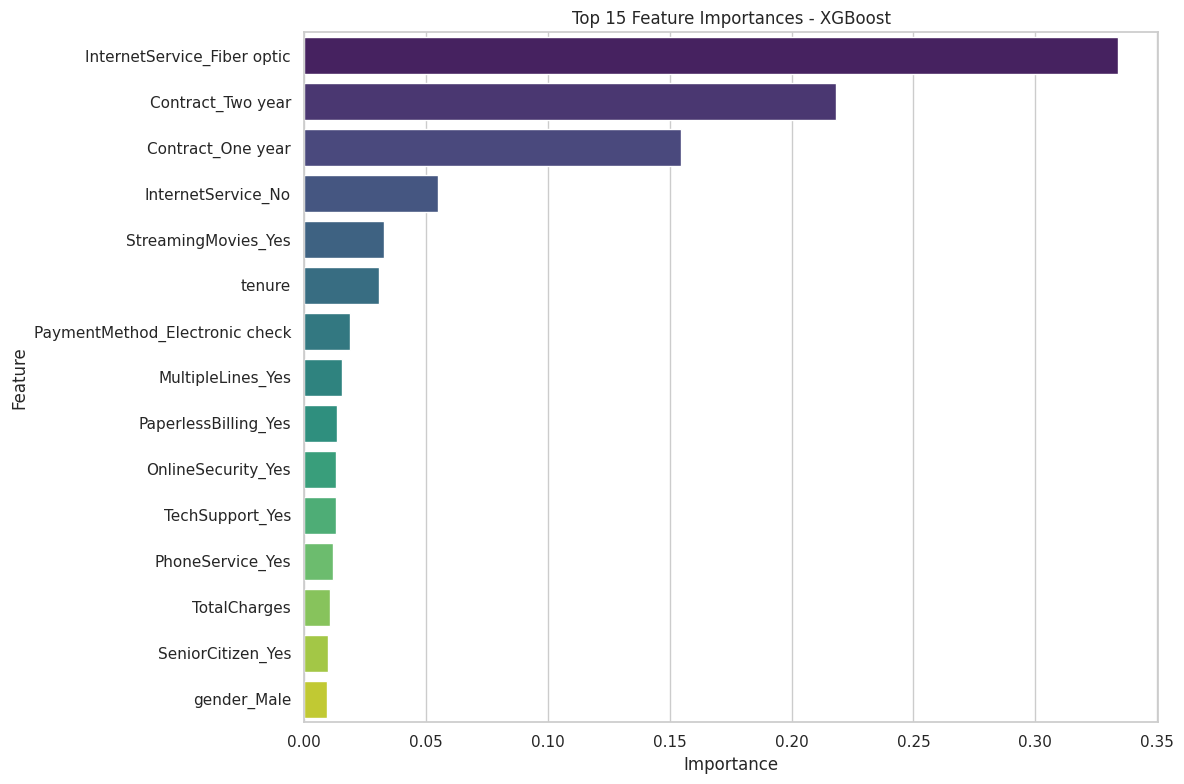


Top 10 most important features:
                           Feature  Importance
10     InternetService_Fiber optic    0.333771
25               Contract_Two year    0.218332
24               Contract_One year    0.154680
11              InternetService_No    0.054935
23             StreamingMovies_Yes    0.032568
0                           tenure    0.030661
28  PaymentMethod_Electronic check    0.018891
9                MultipleLines_Yes    0.015646
26            PaperlessBilling_Yes    0.013270
13              OnlineSecurity_Yes    0.013144


In [ ]:
# Extract the best model based on ROC AUC
best_model_name = models_comparison.loc['ROC AUC'].idxmax()
best_pipeline = None

if best_model_name == 'Random Forest':
    best_pipeline = rf_pipeline
elif best_model_name == 'Gradient Boosting':
    best_pipeline = gb_pipeline
else:
    best_pipeline = xgb_pipeline

print(f"\nAnalyzing feature importance for the best model: {best_model_name}")

# Get feature names from the preprocessor
# For the pipeline, we need to extract the feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Get feature importances
# Note that the specific method depends on the model
if best_model_name == 'XGBoost':
    importances = best_pipeline.named_steps['classifier'].feature_importances_
else:
    importances = best_pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame for easier handling
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title(f'Top 15 Feature Importances - {best_model_name}')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance_df.head(10))


This visualization shows the feature importance scores from your XGBoost model, revealing which customer attributes most strongly influence churn predictions. These importance values represent the relative contribution of each feature to the model's predictive power, measured by the gain (improvement in accuracy) each feature provides when used in decision tree splits.

The horizontal bars represent the magnitude of each feature's importance - longer bars indicate features that have a greater impact on predicting whether a customer will churn. XGBoost calculates these values based on how frequently a feature is used in tree decisions and how much each use improves prediction accuracy.

##Business Interpretation & Strategic Implications

###Primary Churn Drivers

Internet Service Type (Fiber Optic): The dominant feature by a significant margin. Customers with fiber optic internet appear to churn at much higher rates. This suggests potential issues with:

- Reliability or quality of the fiber service
Price-to-value perception for premium internet
Customer expectations not being met for high-speed service

- Price sensitivity: Fiber optic service typically costs more than DSL. Customers who select this higher-tier service might be more price-sensitive and likely to shop around for better deals when their promotional rates expire.

- Bundling issues: If fiber optic services aren't well-integrated with other services like TV or phone, customers might experience friction that DSL customers don't face. => interaction terms with the services might reveal that

- Demographic factors: The correlation might actually be capturing an underlying demographic variable. Perhaps younger, more tech-savvy customers both prefer fiber and are more likely to switch providers regardless of service type.=> interaction terms with the senior status might reveal that


Contract Length: Both two-year and one-year contracts are strong predictors, likely indicating that customers on longer contracts are significantly less likely to churn (negative correlation). This validates the business value of:

- Focusing on converting month-to-month customers to contracts
Offering incentives for longer-term commitments


No Internet Service: The fourth most important feature suggests a distinct behavioral pattern among voice-only customers that affects churn likelihood.

###Secondary Factors

Additional Services: Features like StreamingMovies_Yes, MultipleLines_Yes, and OnlineSecurity_Yes indicate that service bundling impacts retention. Each additional service creates a "stickier" customer relationship.
Tenure: Customer longevity remains a crucial factor, confirming that churn risk decreases as relationships mature.
Payment Method: Electronic check payments correlate with higher churn risk, possibly indicating less committed customers compared to those using automatic payment methods.

Strategic Recommendations

Fiber Service Improvement: Immediately investigate the fiber optic customer experience:

Conduct technical quality assessments
Survey fiber customers about satisfaction
Analyze support call data specifically for fiber customers


Contract Conversion Program: Develop targeted offers to convert month-to-month customers to contracts:

Create graduated discount tiers for different contract lengths
Bundle premium features with longer contracts
Implement early renewal incentives


Service Bundling Strategy: Design promotional packages encouraging multiple services:

Focus on streaming add-ons and security features
Create bundle discounts that increase with number of services
Implement "try and buy" programs for additional services


Payment Method Migration: Develop initiatives to shift customers away from electronic check payments:

Offer one-time discounts for enrolling in automatic payment
Highlight convenience and potential rewards for automatic payment methods
Consider slight price differentials based on payment method


Retention Resource Allocation: Use this model to:

Score all customers by churn probability
Prioritize high-value customers in high-risk segments
Calculate the ROI of targeted retention offers by segment



The model confirms that contract structure and service bundling are fundamental to reducing churn, while highlighting potentially unexpected issues with your premium fiber service that require immediate investigation. These insights should guide both tactical interventions for at-risk customers and strategic product development decisions.RetryClaude can make mistakes. Please double-check responses.Explanatory 3.7 Sonnet

###6.6 Customer Segmentation by Churn Probability
This will help us identify high-risk customer segments


Customer Distribution by Risk Segment:
risk_segment
Low Risk       4392
Medium Risk    2033
High Risk       618
Name: count, dtype: int64

Actual Churn Rate by Risk Segment:
  Risk Segment  Actual Churn Rate (%)
0    High Risk              87.055016
1     Low Risk               6.420765
2  Medium Risk              51.598623


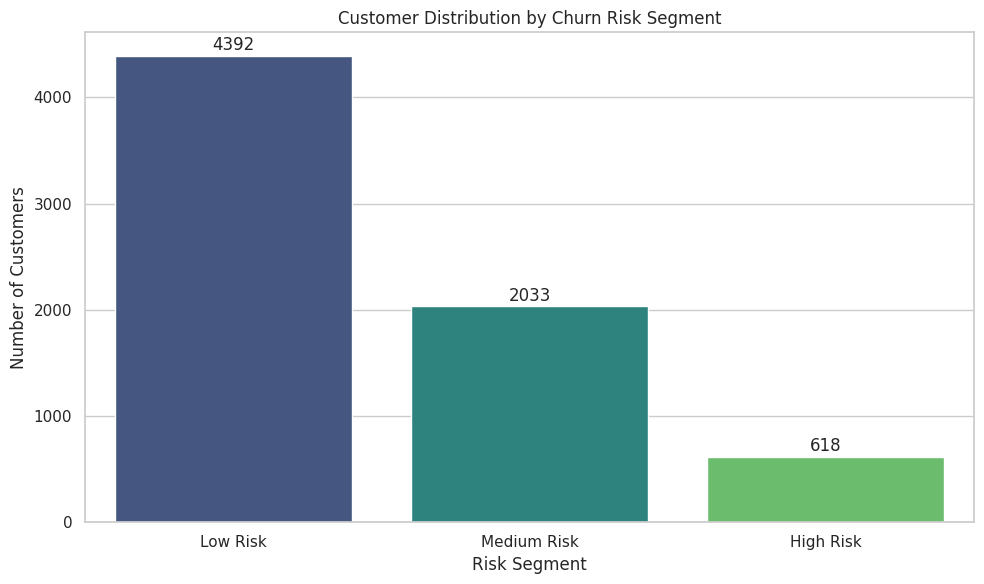

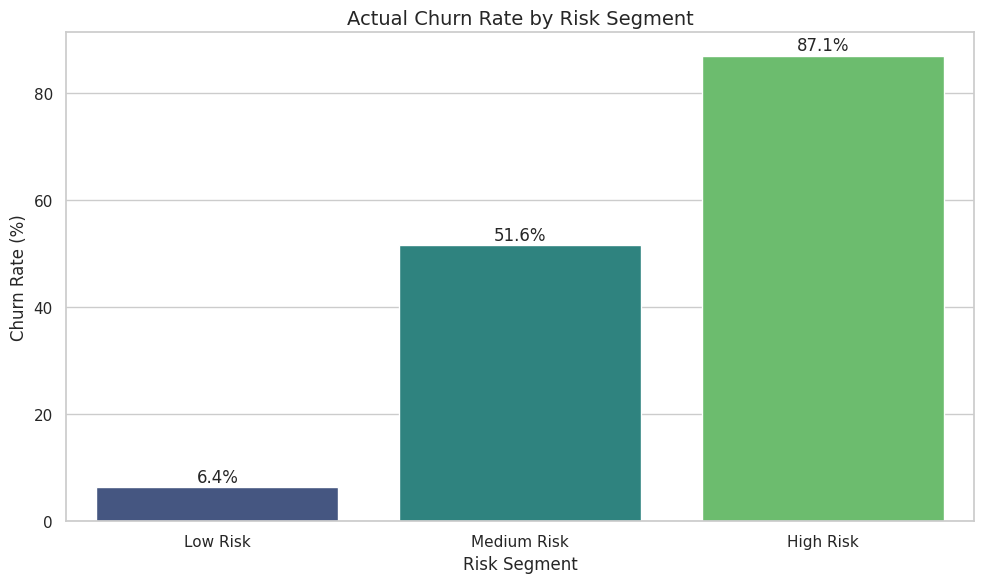

In [ ]:
# Use the best model to predict churn probabilities for all customers
churn_probabilities = best_pipeline.predict_proba(X)[:, 1]

# Add churn probabilities to the customer data
customer_data_with_probs = customer_data.copy()
customer_data_with_probs['churn_probability'] = churn_probabilities

# Define risk segments
def assign_risk_segment(probability):
    if probability < 0.3:
        return 'Low Risk'
    elif probability < 0.7:
        return 'Medium Risk'
    else:
        return 'High Risk'

customer_data_with_probs['risk_segment'] = customer_data_with_probs['churn_probability'].apply(assign_risk_segment)

# Count customers in each risk segment
risk_segment_counts = customer_data_with_probs['risk_segment'].value_counts()

print("\nCustomer Distribution by Risk Segment:")
print(risk_segment_counts)

# Calculate actual churn rate within each risk segment
risk_segment_churn_rates = customer_data_with_probs.groupby('risk_segment')['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100
).reset_index()
risk_segment_churn_rates.columns = ['Risk Segment', 'Actual Churn Rate (%)']

print("\nActual Churn Rate by Risk Segment:")
print(risk_segment_churn_rates)

# Plot risk segment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='risk_segment', data=customer_data_with_probs, palette='viridis',
              order=['Low Risk', 'Medium Risk', 'High Risk'])
plt.title('Customer Distribution by Churn Risk Segment')
plt.xlabel('Risk Segment')
plt.ylabel('Number of Customers')

# Add count labels
for i, count in enumerate(risk_segment_counts):
    plt.text(i, count + 50, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Plot actual churn rate by risk segment with proper label alignment
plt.figure(figsize=(10, 6))

# Ensure the order is explicitly defined
segment_order = ['Low Risk', 'Medium Risk', 'High Risk']

# Create the bar plot with fixed order
ax = sns.barplot(x='Risk Segment', y='Actual Churn Rate (%)',
            data=risk_segment_churn_rates, palette='viridis',
            order=segment_order)

plt.title('Actual Churn Rate by Risk Segment', fontsize=14)
plt.xlabel('Risk Segment', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

# Ensure x-tick labels are properly aligned with bars
plt.xticks(range(len(segment_order)), segment_order)

# Add percentage labels above each bar
for i, rate in enumerate(risk_segment_churn_rates.set_index('Risk Segment').loc[segment_order, 'Actual Churn Rate (%)']):
    plt.text(i, rate + 1, f"{rate:.1f}%", ha='center', fontsize=12)

# Adjust layout to prevent cutoff
plt.tight_layout()
plt.show()

###How Churn Probability Predictions Work
The churn probability predictions you see in your visualization are generated through a sophisticated multi-step process that transforms raw customer data into precise risk scores. Here's how it works:

####The Technical Prediction Process

- Feature Processing: First, your raw telecom customer data undergoes preprocessing:

Numerical features (like tenure and monthly charges) are standardized to have the same scale
Categorical features (like contract type and internet service) are converted to binary indicators through one-hot encoding
Missing values are handled through appropriate imputation techniques


- Decision Tree Construction: XGBoost builds hundreds of sequential decision trees, each focusing on correcting errors from previous trees:

Each tree examines specific patterns in the data (e.g., "Does this customer have fiber internet AND a month-to-month contract?")
Trees become increasingly specialized at identifying subtle churn indicators
Each split in a tree represents a decision point (e.g., "Is tenure < 12 months?")


- Probability Calculation: For each customer, the model:

Runs their data through all trees in the ensemble
Aggregates the predictions from all trees
Applies a logistic function to convert the aggregated score into a probability between 0 and 1


- Mathematical Foundation: The final probability is calculated as:

P(churn) = 1 / (1 + e^-f(x))

Where f(x) is the sum of all tree outputs, weighted by the learning rate

####Business Translation
In simpler terms, the model:

- Analyzes each customer's complete profile against historical churn patterns

- Identifies combinations of risk factors unique to your telecom business

- Weighs the importance of each factor based on its predictive power

- Produces a personalized risk score reflecting each customer's likelihood of leaving

For example, a customer with a 75% churn probability means that, based on historical data, 3 out of 4 customers with similar characteristics ended up leaving the company.

### 6.7 High-Risk Customer Profile Analysis
Analyze the profile of high-risk customers

In [ ]:
# Filter for high-risk customers
high_risk_customers = customer_data_with_probs[customer_data_with_probs['risk_segment'] == 'High Risk']

# Number of high-risk customers
print(f"\nNumber of high-risk customers: {len(high_risk_customers)}")
print(f"Percentage of customer base at high risk: {len(high_risk_customers) / len(customer_data_with_probs) * 100:.2f}%")

# Calculate the potential revenue impact of high-risk customers
monthly_revenue_at_risk = high_risk_customers['MonthlyCharges'].sum()
annual_revenue_at_risk = monthly_revenue_at_risk * 12

print(f"\nMonthly revenue at risk: ${monthly_revenue_at_risk:.2f}")
print(f"Annual revenue at risk: ${annual_revenue_at_risk:.2f}")

# High-risk customer profile
print("\nProfile of High-Risk Customers:")

# Categorical variables analysis
for col in categorical_cols:
    high_risk_profile = high_risk_customers[col].value_counts(normalize=True) * 100
    overall_profile = customer_data_with_probs[col].value_counts(normalize=True) * 100

    # Calculate difference from overall customer base
    diff_profile = high_risk_profile - overall_profile

    # Get the top categories with the largest positive difference
    top_diff = diff_profile.sort_values(ascending=False).head(3)

    if not top_diff.empty:
        top_category = top_diff.index[0]
        diff_value = top_diff.iloc[0]

        if diff_value > 5:  # Only report significant differences
            print(f"- {col}: {diff_value:.1f}% more likely to be '{top_category}' compared to overall customer base")

# Numerical variables analysis
for col in numerical_cols:
    high_risk_mean = high_risk_customers[col].mean()
    overall_mean = customer_data_with_probs[col].mean()

    # Calculate percentage difference
    pct_diff = (high_risk_mean - overall_mean) / overall_mean * 100

    if abs(pct_diff) > 10:  # Only report significant differences
        direction = "higher" if pct_diff > 0 else "lower"
        print(f"- {col}: {abs(pct_diff):.1f}% {direction} than overall customer base")


Number of high-risk customers: 618
Percentage of customer base at high risk: 8.77%

Monthly revenue at risk: $51229.30
Annual revenue at risk: $614751.60

Profile of High-Risk Customers:
- SeniorCitizen: 16.5% more likely to be 'Yes' compared to overall customer base
- Partner: 21.3% more likely to be 'No' compared to overall customer base
- Dependents: 20.6% more likely to be 'No' compared to overall customer base
- MultipleLines: 14.8% more likely to be 'Yes' compared to overall customer base
- InternetService: 50.2% more likely to be 'Fiber optic' compared to overall customer base
- OnlineSecurity: 45.5% more likely to be 'No' compared to overall customer base
- OnlineBackup: 36.9% more likely to be 'No' compared to overall customer base
- DeviceProtection: 32.3% more likely to be 'No' compared to overall customer base
- TechSupport: 45.8% more likely to be 'No' compared to overall customer base
- StreamingTV: 11.7% more likely to be 'No' compared to overall customer base
- Streami

*Business Portrait of High-Risk Customer Segment*

High-risk customers tend to be senior citizens, often single without partners or dependents. They frequently subscribe to multiple phone lines and predominantly opt for Fiber Optic internet service. These customers typically forgo additional online services such as security, backup, device protection, and tech support. While they usually don't stream TV, they do often stream movies.

High-risk customers prefer month-to-month contracts, are inclined towards paperless billing, and commonly use electronic checks for payments. They have notably shorter tenure with the company, incur significantly higher monthly charges, yet have lower overall lifetime charges—indicating frequent churn and limited customer longevity.

###6.8 Model Deployment Considerations

In [ ]:
print("\nModel Deployment Considerations:")
print("1. Model Refresh Frequency: The model should be refreshed quarterly to account for changing customer behavior patterns.")
print("2. Performance Monitoring: Track key metrics like precision and recall over time to ensure the model remains effective.")
print("3. Threshold Tuning: The probability threshold for classifying a customer as 'high risk' can be adjusted based on business priorities.")
print("4. Integration: The model should be integrated with customer relationship management (CRM) systems for real-time risk assessment.")
print("5. Feedback Loop: Establish a process to collect data on the effectiveness of retention interventions to improve future models.")




Model Deployment Considerations:
1. Model Refresh Frequency: The model should be refreshed quarterly to account for changing customer behavior patterns.
2. Performance Monitoring: Track key metrics like precision and recall over time to ensure the model remains effective.
3. Threshold Tuning: The probability threshold for classifying a customer as 'high risk' can be adjusted based on business priorities.
4. Integration: The model should be integrated with customer relationship management (CRM) systems for real-time risk assessment.
5. Feedback Loop: Establish a process to collect data on the effectiveness of retention interventions to improve future models.


# 7. Business Recommendations Based on Model Insights

In [ ]:
print("\nBusiness Recommendations:")
print("1. Targeted Retention Program: Implement personalized retention offers for high-risk customers.")
print("2. Service Improvement: Address key issues identified in customer complaints, particularly for fiber optic internet users.")
print("3. Contract Incentives: Encourage month-to-month customers to switch to longer contracts with appropriate incentives.")
print("4. Technical Support Enhancement: Improve technical support services, especially for customers with premium services.")
print("5. Early Intervention: Establish an early warning system to identify customers showing signs of dissatisfaction.")
print("6. Customer Education: Provide better onboarding and usage guidance for new customers with advanced services.")
print("7. Value Enhancement: Create bundled offers that increase perceived value without significantly increasing costs.")



Business Recommendations:
1. Targeted Retention Program: Implement personalized retention offers for high-risk customers.
2. Service Improvement: Address key issues identified in customer complaints, particularly for fiber optic internet users.
3. Contract Incentives: Encourage month-to-month customers to switch to longer contracts with appropriate incentives.
4. Technical Support Enhancement: Improve technical support services, especially for customers with premium services.
5. Early Intervention: Establish an early warning system to identify customers showing signs of dissatisfaction.
6. Customer Education: Provide better onboarding and usage guidance for new customers with advanced services.
7. Value Enhancement: Create bundled offers that increase perceived value without significantly increasing costs.


# Summary


In [ ]:
print("\nModeling Summary:")
print(f"- Best performing model: {best_model_name} with ROC AUC of {models_comparison.loc['ROC AUC', best_model_name]:.4f}")
print(f"- Number of high-risk customers identified: {len(high_risk_customers)}")
print(f"- Annual revenue at risk: ${annual_revenue_at_risk:.2f}")
print("- Top churn drivers: Contract type, Internet service type, and Tenure")
print("- Recommendation: Implement targeted retention strategies for high-risk segments to reduce annual churn rate")


Modeling Summary:
- Best performing model: XGBoost with ROC AUC of 0.8424
- Number of high-risk customers identified: 618
- Annual revenue at risk: $614751.60
- Top churn drivers: Contract type, Internet service type, and Tenure
- Recommendation: Implement targeted retention strategies for high-risk segments to reduce annual churn rate


# 8. Advanced XGBoost Model for Churn Prediction & Interpretation

In this section, we'll build and fine-tune an optimized XGBoost model for predicting customer churn.
We'll use a systematic approach to:

1. Optimize hyperparameters with cross-validation
2. Evaluate model performance with business-relevant metrics
3. Interpret the model using SHAP values
4. Create actionable customer segments based on churn probabilities
5. Analyze the ROI of potential retention strategies

In [ ]:
# Import additional libraries needed for this section
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_recall_curve,
                            average_precision_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import time
from scipy.stats import randint, uniform

# Set random seed for reproducibility
np.random.seed(42)

## 8.1 Preparing the Data with Enhanced Features

In [ ]:
print("8.1 Preparing the Data with Enhanced Features")

# Make a copy of the original data to avoid modifying it
customer_data_enhanced = customer_data.copy()

# Add engineered features based on our EDA insights
# These features encapsulate important patterns we observed

# 1. Create a service count feature (number of additional services)
def count_services(row):
    services = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    count = 0

    # Count phone services
    if row['PhoneService'] == 'Yes':
        count += 1
        if row['MultipleLines'] == 'Yes':
            count += 1

    # Count internet-related services
    if row['InternetService'] != 'No':
        for service in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                      'TechSupport', 'StreamingTV', 'StreamingMovies']:
            if row[service] == 'Yes':
                count += 1

    return count

customer_data_enhanced['ServiceCount'] = customer_data_enhanced.apply(count_services, axis=1)

# 2. Calculate average monthly spend (total charges / tenure)
# First convert TotalCharges to numeric if it's not already
customer_data_enhanced['TotalCharges'] = pd.to_numeric(customer_data_enhanced['TotalCharges'], errors='coerce')
customer_data_enhanced['TotalCharges'].fillna(0, inplace=True)

# Avoid division by zero for new customers
customer_data_enhanced['AvgMonthlySpend'] = np.where(
    customer_data_enhanced['tenure'] > 0,
    customer_data_enhanced['TotalCharges'] / customer_data_enhanced['tenure'],
    customer_data_enhanced['MonthlyCharges']
)

# 3. Create a feature for customers who might be near contract renewal
# Assuming contracts are typically for 12, 24, or 36 months
customer_data_enhanced['NearContractRenewal'] = (
    ((customer_data_enhanced['Contract'] == 'One year') &
     (customer_data_enhanced['tenure'] % 12 >= 10)) |
    ((customer_data_enhanced['Contract'] == 'Two year') &
     (customer_data_enhanced['tenure'] % 24 >= 22))
).astype(int)

# 4. Identify high-value customers (top 25% by monthly charges)
high_value_threshold = customer_data_enhanced['MonthlyCharges'].quantile(0.75)
customer_data_enhanced['HighValueCustomer'] = (
    customer_data_enhanced['MonthlyCharges'] >= high_value_threshold
).astype(int)

# Print summary of new features
print("\nSummary of enhanced features:")
for feature in ['ServiceCount', 'AvgMonthlySpend', 'NearContractRenewal', 'HighValueCustomer']:
    if feature in ['NearContractRenewal', 'HighValueCustomer']:
        print(f"{feature}: {customer_data_enhanced[feature].sum()} customers")
    else:
        print(f"{feature}: mean = {customer_data_enhanced[feature].mean():.2f}, " +
              f"min = {customer_data_enhanced[feature].min():.2f}, " +
              f"max = {customer_data_enhanced[feature].max():.2f}")

# Select features for the enhanced model, including our new engineered features
X_enhanced = customer_data_enhanced.drop(
    ['customerID', 'Churn', 'tenure_group', 'charges_group', 'service_count'],
    axis=1, errors='ignore'
)
y = (customer_data_enhanced['Churn'] == 'Yes').astype(int)

# Split the enhanced data
X_train_enhanced, X_test_enhanced, y_train, y_test = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nEnhanced training set shape: {X_train_enhanced.shape}")
print(f"Enhanced test set shape: {X_test_enhanced.shape}")

# Create lists of categorical and numerical columns, including new features
categorical_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

numerical_cols = [
    'tenure', 'MonthlyCharges', 'TotalCharges',
    'ServiceCount', 'AvgMonthlySpend', 'NearContractRenewal', 'HighValueCustomer'
]

# Create preprocessor for the enhanced dataset
preprocessor_enhanced = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    verbose_feature_names_out=False
)

8.1 Preparing the Data with Enhanced Features

Summary of enhanced features:
ServiceCount: mean = 3.36, min = 0.00, max = 8.00
AvgMonthlySpend: mean = 64.76, min = 13.78, max = 121.40
NearContractRenewal: 556 customers
HighValueCustomer: 1771 customers

Enhanced training set shape: (5634, 23)
Enhanced test set shape: (1409, 23)


## 8.2 Hyperparameter Tuning Using Random Search with Cross-Validation

In [ ]:
print("\n8.2 Hyperparameter Tuning Using Random Search with Cross-Validation")

# Create pipeline with preprocessing
pipeline = Pipeline([
    ('preprocessor', preprocessor_enhanced),
    ('classifier', xgb.XGBClassifier(objective='binary:logistic', random_state=42))
])

# Define parameter space for random search
param_dist = {
    'classifier__n_estimators': randint(50, 300),
    'classifier__max_depth': randint(3, 10),
    'classifier__learning_rate': uniform(0.01, 0.3),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__gamma': uniform(0, 5),
    'classifier__min_child_weight': randint(1, 10),
    'classifier__reg_alpha': uniform(0, 2),
    'classifier__reg_lambda': uniform(0, 2),
    'classifier__scale_pos_weight': [sum(y_train == 0) / sum(y_train == 1)]  # Handle class imbalance
}

# Use stratified k-fold to maintain class imbalance in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up random search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=25,  # Number of parameter settings sampled
    scoring='roc_auc',  # Optimize for ROC AUC
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit random search
start_time = time.time()
print("Starting random search for optimal hyperparameters...")
random_search.fit(X_train_enhanced, y_train)
print(f"Random search completed in {(time.time() - start_time) / 60:.2f} minutes")

# Print best parameters and score
print("\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")
print(f"Best Cross-Validation ROC AUC: {random_search.best_score_:.4f}")

# Create final model with best parameters
best_params = random_search.best_params_
best_model = Pipeline([
    ('preprocessor', preprocessor_enhanced),
    ('classifier', xgb.XGBClassifier(
        n_estimators=best_params['classifier__n_estimators'],
        max_depth=best_params['classifier__max_depth'],
        learning_rate=best_params['classifier__learning_rate'],
        subsample=best_params['classifier__subsample'],
        colsample_bytree=best_params['classifier__colsample_bytree'],
        gamma=best_params['classifier__gamma'],
        min_child_weight=best_params['classifier__min_child_weight'],
        reg_alpha=best_params['classifier__reg_alpha'],
        reg_lambda=best_params['classifier__reg_lambda'],
        scale_pos_weight=best_params['classifier__scale_pos_weight'],
        objective='binary:logistic',
        random_state=42
    ))
])

# Train final model
print("\nTraining final model with optimized hyperparameters...")
best_model.fit(X_train_enhanced, y_train)
print("Model training complete!")


8.2 Hyperparameter Tuning Using Random Search with Cross-Validation
Starting random search for optimal hyperparameters...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Random search completed in 0.90 minutes

Best Parameters:
classifier__colsample_bytree: 0.8118602313424026
classifier__gamma: 1.2092614545022584
classifier__learning_rate: 0.037930830341769764
classifier__max_depth: 6
classifier__min_child_weight: 5
classifier__n_estimators: 86
classifier__reg_alpha: 1.7652726863786794
classifier__reg_lambda: 0.37741421668275876
classifier__scale_pos_weight: 2.768561872909699
classifier__subsample: 0.7115485410368727
Best Cross-Validation ROC AUC: 0.8472

Training final model with optimized hyperparameters...
Model training complete!


## 8.3 Advanced Model Evaluation


8.3 Advanced Model Evaluation

Model Performance Metrics:
Accuracy: 0.7544
Precision: 0.5245
Recall: 0.8021
F1 Score: 0.6342
ROC AUC: 0.8473
Average Precision (PR AUC): 0.6599

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1035
           1       0.52      0.80      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.77      1409



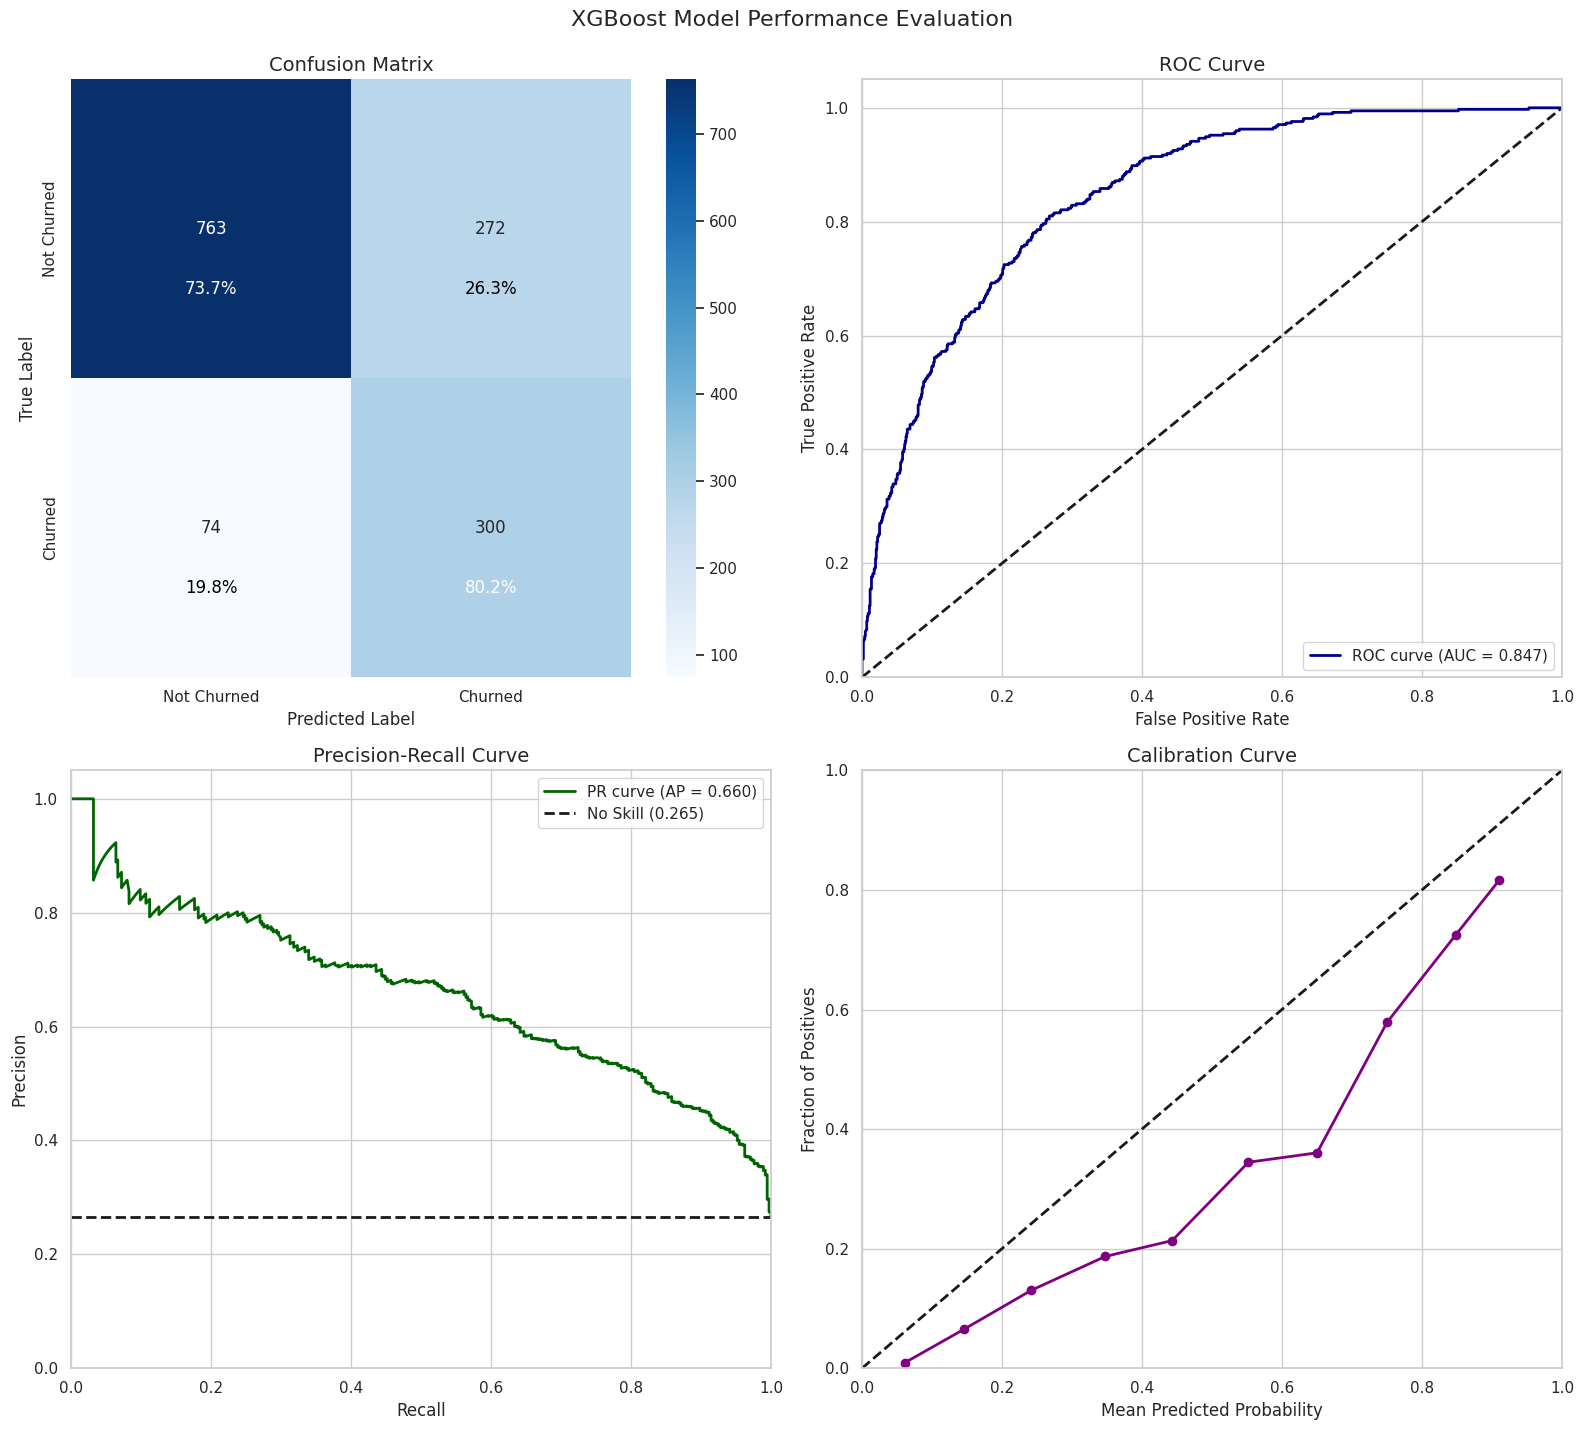

In [ ]:
print("\n8.3 Advanced Model Evaluation")

# Get predictions on test set
y_pred = best_model.predict(X_test_enhanced)
y_pred_proba = best_model.predict_proba(X_test_enhanced)[:, 1]

# Calculate standard metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Print metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision (PR AUC): {avg_precision:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualization of model performance
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Confusion Matrix
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Churned', 'Churned'],
    yticklabels=['Not Churned', 'Churned'],
    ax=axes[0, 0]
)
axes[0, 0].set_title('Confusion Matrix', fontsize=14)
axes[0, 0].set_ylabel('True Label', fontsize=12)
axes[0, 0].set_xlabel('Predicted Label', fontsize=12)

# Add percentages to confusion matrix
cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[0, 0].text(
            j + 0.5, i + 0.7,
            f"{cm_percentages[i, j]:.1%}",
            ha='center', va='center',
            color='white' if i == j else 'black'
        )

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0, 1].plot(fpr, tpr, lw=2, color='darkblue', label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 1].set_title('ROC Curve', fontsize=14)
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(True)

# 3. Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
axes[1, 0].plot(recall_curve, precision_curve, lw=2, color='darkgreen',
               label=f'PR curve (AP = {avg_precision:.3f})')
axes[1, 0].set_xlabel('Recall', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Precision-Recall Curve', fontsize=14)
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
# Add no-skill line (baseline)
no_skill = len(y_test[y_test == 1]) / len(y_test)
axes[1, 0].plot([0, 1], [no_skill, no_skill], 'k--', lw=2, label=f'No Skill ({no_skill:.3f})')
axes[1, 0].legend(loc="upper right")
axes[1, 0].grid(True)

# 4. Calibration Curve (Reliability Diagram)
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
axes[1, 1].plot(prob_pred, prob_true, marker='o', linewidth=2, color='purple')
axes[1, 1].plot([0, 1], [0, 1], 'k--', lw=2)  # Perfect calibration line
axes[1, 1].set_xlabel('Mean Predicted Probability', fontsize=12)
axes[1, 1].set_ylabel('Fraction of Positives', fontsize=12)
axes[1, 1].set_title('Calibration Curve', fontsize=14)
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.0])
axes[1, 1].grid(True)

plt.tight_layout()
plt.suptitle('XGBoost Model Performance Evaluation', fontsize=16, y=1.02)
plt.show()

# 8.4 Feature Importance and Model Interpretation with SHAP


8.4 Feature Importance and Model Interpretation with SHAP


<Figure size 1200x600 with 0 Axes>

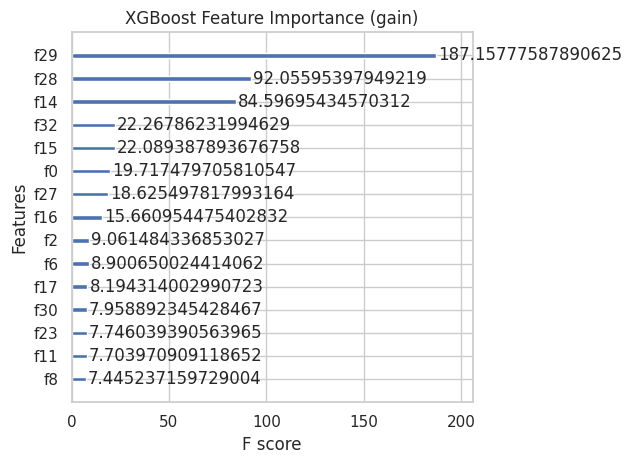


Calculating SHAP values for model interpretation...


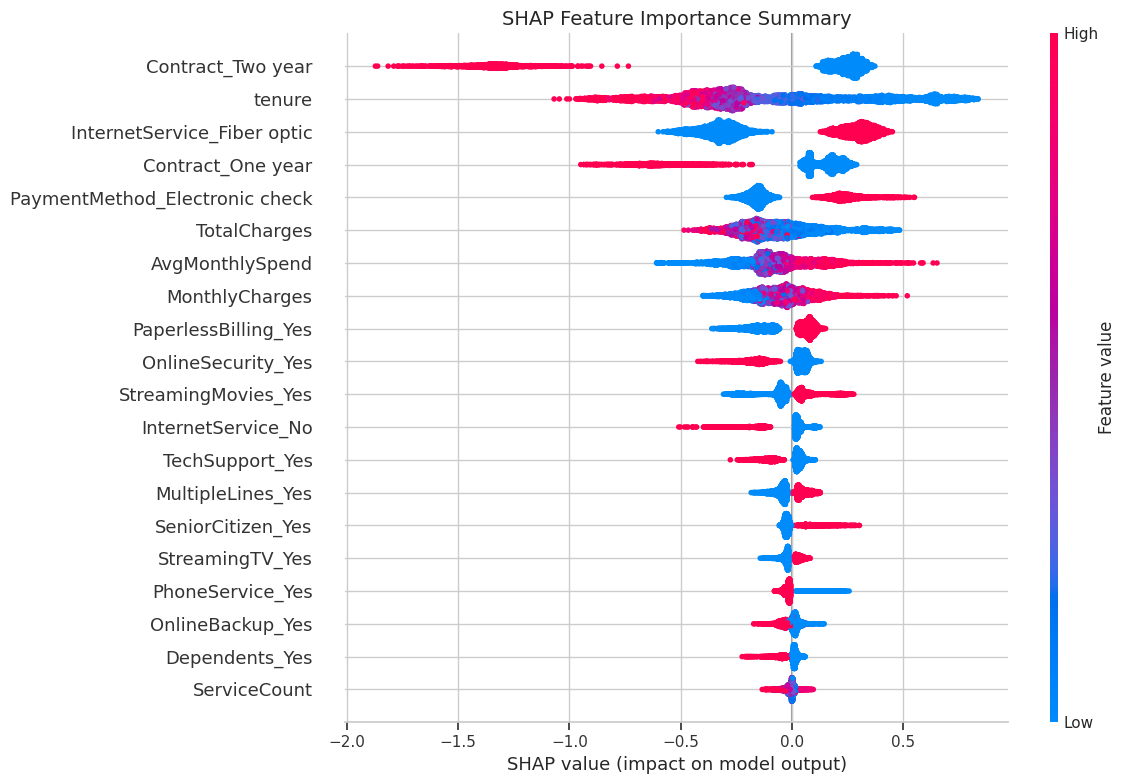


Top 3 features with highest impact on predictions:
1. Contract_Two year
2. tenure
3. InternetService_Fiber optic


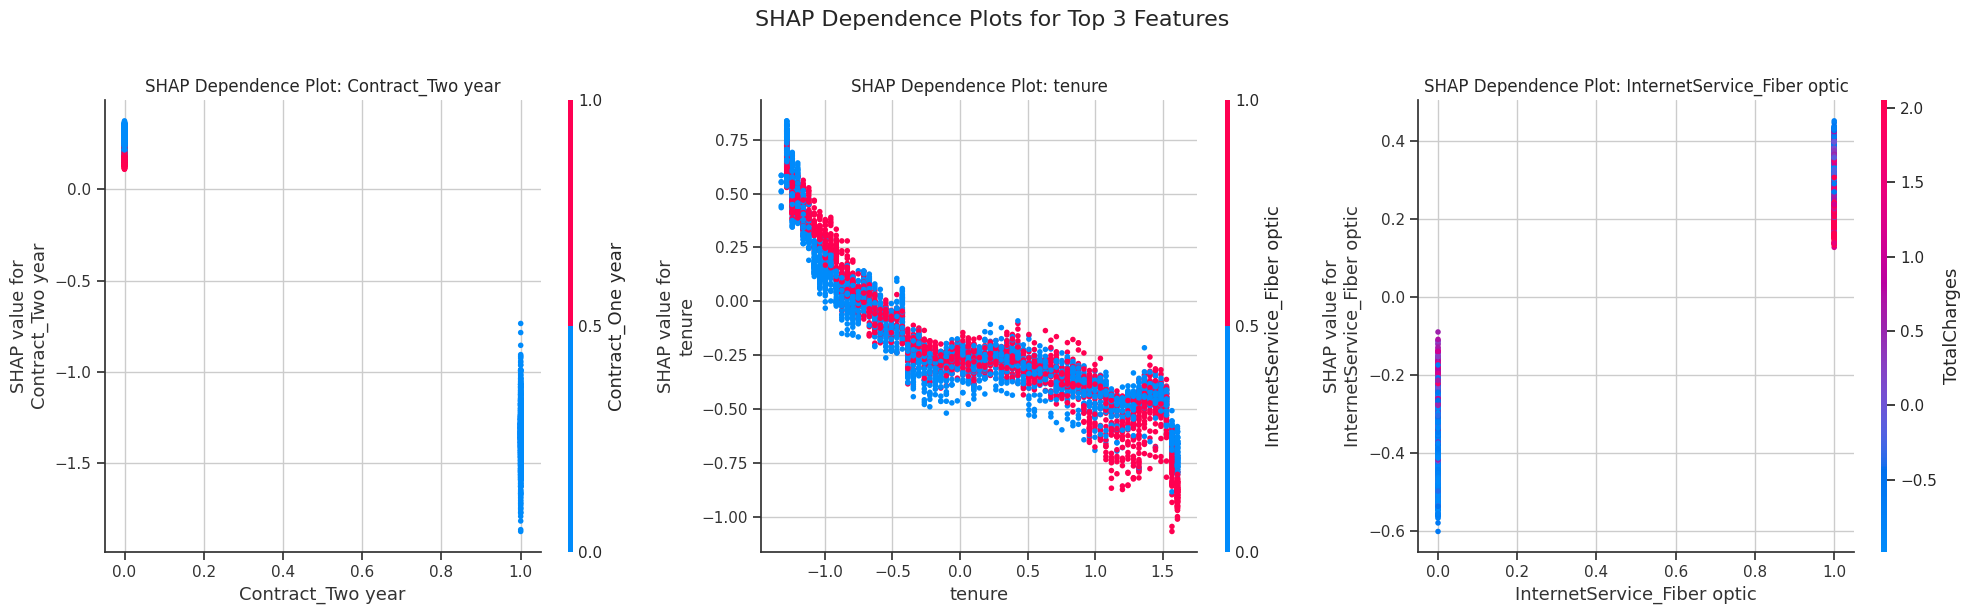

In [ ]:
print("\n8.4 Feature Importance and Model Interpretation with SHAP")

# Extract the preprocessor and model from the pipeline
preprocessor = best_model.named_steps['preprocessor']
classifier = best_model.named_steps['classifier']

# Apply preprocessing to the training data
X_train_processed = preprocessor.transform(X_train_enhanced)

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Traditional feature importance from XGBoost
plt.figure(figsize=(12, 6))
xgb.plot_importance(
    classifier,
    max_num_features=15,
    importance_type='gain',
    title='XGBoost Feature Importance (gain)'
)
plt.tight_layout()
plt.show()

# Create SHAP explainer
print("\nCalculating SHAP values for model interpretation...")
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_train_processed)

# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_train_processed,
    feature_names=feature_names,
    plot_size=(12, 8),
    show=False
)
plt.title('SHAP Feature Importance Summary', fontsize=14)
plt.tight_layout()
plt.show()

# SHAP dependence plots for top 3 features
top_features_idx = np.argsort(-np.abs(shap_values).mean(0))[:3]
top_features = [feature_names[i] for i in top_features_idx]

print(f"\nTop 3 features with highest impact on predictions:")
for i, feature in enumerate(top_features):
    print(f"{i+1}. {feature}")

# SHAP dependence plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, feature_idx in enumerate(top_features_idx):
    feature_name = feature_names[feature_idx]
    shap.dependence_plot(
        feature_idx,
        shap_values,
        X_train_processed,
        feature_names=feature_names,
        ax=axes[i],
        show=False
    )
    axes[i].set_title(f'SHAP Dependence Plot: {feature_name}', fontsize=12)

plt.suptitle('SHAP Dependence Plots for Top 3 Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 8.5 Threshold Optimization for Business Impact


8.5 Threshold Optimization for Business Impact

Optimal threshold for business profit: 0.50
Estimated profit at this threshold: $41342.63

Threshold evaluation:
    Threshold  Precision  Recall  F1 Score  Estimated Profit
0        0.10      0.340   0.992     0.506         31945.716
1        0.15      0.364   0.973     0.530         34913.722
2        0.20      0.390   0.963     0.556         37831.153
3        0.25      0.420   0.941     0.580         40116.017
4        0.30      0.436   0.914     0.591         40534.596
5        0.35      0.460   0.882     0.605         41086.891
6        0.40      0.483   0.853     0.616         41322.328
7        0.45      0.504   0.821     0.625         41124.623
8        0.50      0.524   0.802     0.634         41342.628
9        0.55      0.546   0.751     0.632         39762.928
10       0.60      0.572   0.693     0.626         37733.802
11       0.65      0.612   0.628     0.620         35588.392
12       0.70      0.662   0.561     0.608   

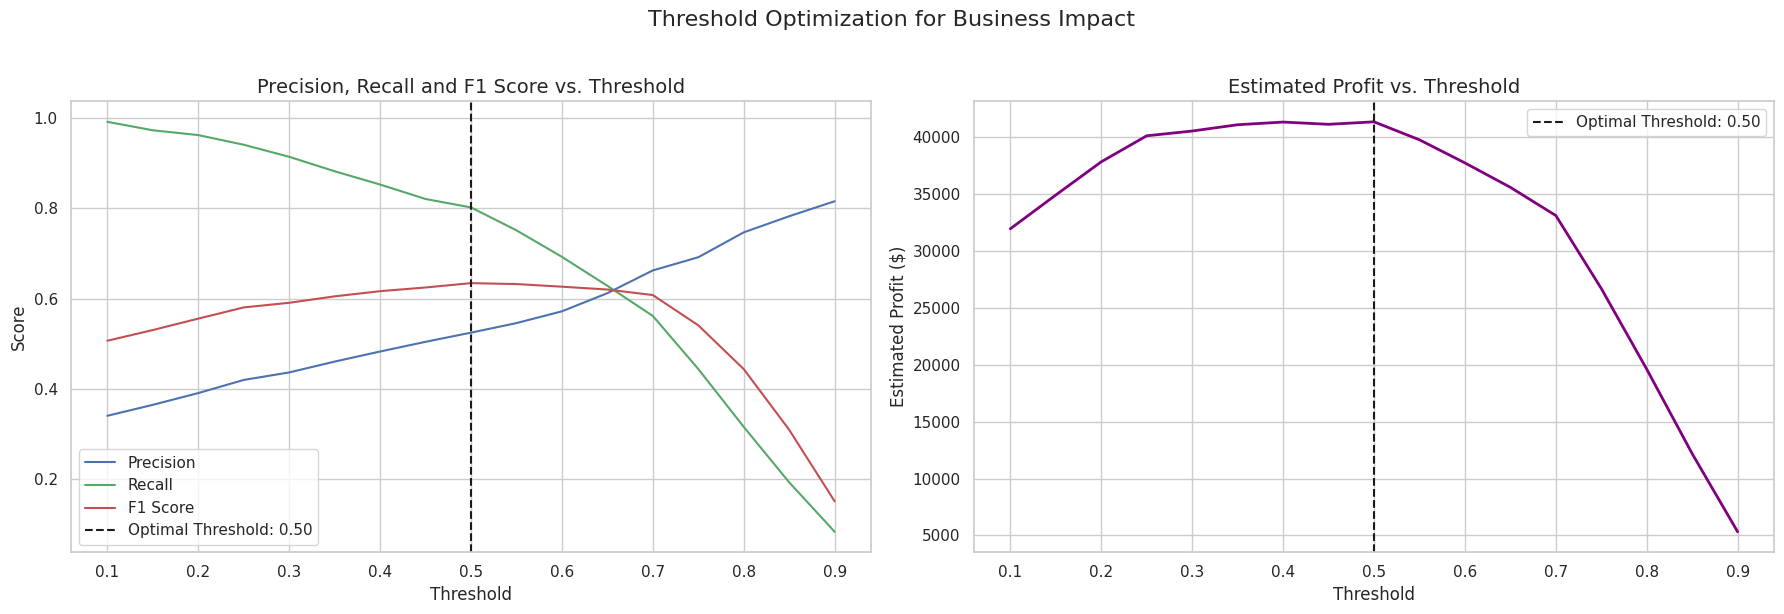

In [ ]:
print("\n8.5 Threshold Optimization for Business Impact")

# Calculate precision, recall, and F1 for different thresholds
thresholds = np.arange(0.1, 0.91, 0.05)
precision_scores = []
recall_scores = []
f1_scores = []
profit_scores = []  # Assuming profit calculation based on business metrics

# Assume some business parameters
# These should be adjusted based on your business context
avg_customer_value = customer_data_enhanced['MonthlyCharges'].mean() * 12  # Annual value
retention_campaign_cost = 50  # Cost per customer for retention campaign
success_rate = 0.3  # Assume 30% success rate for retention efforts

for threshold in thresholds:
    y_pred_th = (y_pred_proba >= threshold).astype(int)

    # Calculate metrics
    prec = precision_score(y_test, y_pred_th)
    rec = recall_score(y_test, y_pred_th)
    f1 = f1_score(y_test, y_pred_th)

    # Business profit calculation
    # True positives: correctly identified churners who we retain with our campaign
    tp = ((y_test == 1) & (y_pred_th == 1)).sum()
    # False positives: incorrectly identified as churners (waste campaign cost)
    fp = ((y_test == 0) & (y_pred_th == 1)).sum()

    # Calculate profit
    retained_value = tp * success_rate * avg_customer_value  # Value from retained customers
    campaign_cost = (tp + fp) * retention_campaign_cost  # Cost of campaign
    profit = retained_value - campaign_cost

    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)
    profit_scores.append(profit)

# Find optimal threshold for profit
optimal_idx = np.argmax(profit_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_profit = profit_scores[optimal_idx]

# Create a summary DataFrame
threshold_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'Estimated Profit': profit_scores
})

print(f"\nOptimal threshold for business profit: {optimal_threshold:.2f}")
print(f"Estimated profit at this threshold: ${optimal_profit:.2f}")
print("\nThreshold evaluation:")
print(threshold_df.round(3))

# Plot threshold optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot metrics against threshold
ax1.plot(thresholds, precision_scores, 'b-', label='Precision')
ax1.plot(thresholds, recall_scores, 'g-', label='Recall')
ax1.plot(thresholds, f1_scores, 'r-', label='F1 Score')
ax1.axvline(x=optimal_threshold, color='k', linestyle='--',
           label=f'Optimal Threshold: {optimal_threshold:.2f}')
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Precision, Recall and F1 Score vs. Threshold', fontsize=14)
ax1.legend()
ax1.grid(True)

# Plot profit against threshold
ax2.plot(thresholds, profit_scores, 'purple', linewidth=2)
ax2.axvline(x=optimal_threshold, color='k', linestyle='--',
           label=f'Optimal Threshold: {optimal_threshold:.2f}')
ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Estimated Profit ($)', fontsize=12)
ax2.set_title('Estimated Profit vs. Threshold', fontsize=14)
ax2.legend()
ax2.grid(True)

plt.suptitle('Threshold Optimization for Business Impact', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 8.6 Customer Segmentation with Optimized Model

In [ ]:
print("\n8.6 Customer Segmentation with Optimized Model")

# Get predictions for all customers
all_customers_proba = best_model.predict_proba(X_enhanced)[:, 1]

# Add predictions to the customer data
customer_segments = customer_data_enhanced.copy()
customer_segments['churn_probability'] = all_customers_proba

# Apply the optimized threshold
customer_segments['predicted_churn'] = (all_customers_proba >= optimal_threshold).astype(int)

# Create risk segments based on probabilities
def assign_risk_category(prob):
    if prob < 0.3:
        return 'Low Risk'
    elif prob < optimal_threshold:
        return 'Medium Risk'
    elif prob < 0.8:
        return 'High Risk'
    else:
        return 'Very High Risk'

customer_segments['risk_category'] = customer_segments['churn_probability'].apply(assign_risk_category)

# Calculate revenue impact by segment
customer_segments['monthly_revenue'] = customer_segments['MonthlyCharges']
customer_segments['annual_revenue'] = customer_segments['monthly_revenue'] * 12

# Summarize segments
segment_summary = customer_segments.groupby('risk_category').agg(
    customer_count=('customerID', 'count'),
    avg_probability=('churn_probability', 'mean'),
    avg_monthly_revenue=('monthly_revenue', 'mean'),
    total_monthly_revenue=('monthly_revenue', 'sum'),
    total_annual_revenue=('annual_revenue', 'sum'),
    avg_tenure=('tenure', 'mean')
).reset_index()

# Calculate total revenue at risk
segment_summary['revenue_at_risk'] = segment_summary['total_annual_revenue'] * segment_summary['avg_probability']

# Sort by risk category in a logical order
risk_order = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
segment_summary['risk_order'] = segment_summary['risk_category'].map({cat: i for i, cat in enumerate(risk_order)})
segment_summary = segment_summary.sort_values('risk_order').drop('risk_order', axis=1)

print("\nCustomer Segment Summary:")
print(segment_summary.round(2))

# Calculate total revenue at risk
total_revenue_at_risk = segment_summary[segment_summary['risk_category'].isin(['High Risk', 'Very High Risk'])]['revenue_at_risk'].sum()
print(f"\nTotal annual revenue at risk: ${total_revenue_at_risk:.2f}")

# Visualize customer segments
plt.figure(figsize=(14, 8))

# Customer count by segment
ax1 = plt.subplot(2, 2, 1)
sns.countplot(
    x='risk_category',
    data=customer_segments,
    palette='viridis',
    order=risk_order,
    ax=ax1
)
ax1.set_title('Customer Count by Risk Segment', fontsize=12)
ax1.set_xlabel('Risk Category', fontsize=10)
ax1.set_ylabel('Number of Customers', fontsize=10)

# Add count labels
for i, count in enumerate(segment_summary['customer_count']):
    ax1.text(i, count + 10, f"{count}", ha='center', fontsize=10)

# Average probability by segment
ax2 = plt.subplot(2, 2, 2)
sns.barplot(
    x='risk_category',
    y='avg_probability',
    data=segment_summary,
    palette='viridis',
    order=risk_order,
    ax=ax2
)
ax2.set_title('Average Churn Probability by Segment', fontsize=12)
ax2.set_xlabel('Risk Category', fontsize=10)
ax2.set_ylabel('Average Churn Probability', fontsize=10)

# Add probability labels
for i, prob in enumerate(segment_summary['avg_probability']):
    ax2.text(i, prob + 0.02, f"{prob:.2f}", ha='center', fontsize=10)

# Revenue at risk by segment
ax3 = plt.subplot(2, 1, 2)
sns.barplot(
    x='risk_category',
    y='revenue_at_risk',
    data=segment_summary,
    palette='viridis',
    order=risk_order,
    ax=ax3
)
ax3.set_title('Annual Revenue at Risk by Segment', fontsize=12)
ax3.set_xlabel('Risk Category', fontsize=10)
ax3.set_ylabel('Revenue at Risk ($)', fontsize=10)

# Add revenue labels
for i, revenue in enumerate(segment_summary['revenue_at_risk']):
    ax3.text(i, revenue + 5000, f"${revenue:.0f}", ha='center', fontsize=10)

plt.suptitle('Customer Segmentation by Churn Risk', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


8.6 Customer Segmentation with Optimized Model

Customer Segment Summary:
    risk_category  customer_count  avg_probability  avg_monthly_revenue  \
1        Low Risk            3173             0.13                53.25   
2     Medium Risk            1073             0.40                72.58   
0       High Risk            1961             0.66                71.54   
3  Very High Risk             836             0.86                82.52   

   total_monthly_revenue  total_annual_revenue  avg_tenure  revenue_at_risk  
1              168973.75             2027685.0       45.91        257109.61  
2               77873.95              934487.4       34.81        372161.54  
0              140281.85             1683382.2       20.43       1108686.41  
3               68987.05              827844.6        5.88        713797.29  

Total annual revenue at risk: $1822483.70


## 8.7 Target Group Analysis for Retention Campaigns

In [ ]:
print("\n8.7 Target Group Analysis for Retention Campaigns")

# Define the target group for retention campaigns
# These are customers with high risk but also high value
target_group = customer_segments[
    (customer_segments['risk_category'].isin(['High Risk', 'Very High Risk'])) &
    (customer_segments['HighValueCustomer'] == 1)
]

print(f"Number of high-risk, high-value customers to target: {len(target_group)}")
print(f"Average monthly revenue of target group: ${target_group['monthly_revenue'].mean():.2f}")
print(f"Total monthly revenue at risk: ${target_group['monthly_revenue'].sum():.2f}")
print(f"Total annual revenue at risk: ${target_group['annual_revenue'].sum():.2f}")

# Analyze characteristics of target group
print("\nKey characteristics of target group:")

# For categorical features
for col in categorical_cols:
    target_dist = target_group[col].value_counts(normalize=True).reset_index()
    target_dist.columns = ['Value', 'Target Group']

    all_dist = customer_segments[col].value_counts(normalize=True).reset_index()
    all_dist.columns = ['Value', 'All Customers']

    comparison = target_dist.merge(all_dist, on='Value')
    comparison['Difference'] = comparison['Target Group'] - comparison['All Customers']
    comparison = comparison.sort_values('Difference', ascending=False)

    # Only show the top difference
    top_diff = comparison.iloc[0]
    if abs(top_diff['Difference']) > 0.1:  # Only show significant differences
        print(f"- {col}: {top_diff['Value']} ({(top_diff['Target Group']*100):.1f}% vs {(top_diff['All Customers']*100):.1f}% overall)")

# For numerical features
for col in ['tenure', 'MonthlyCharges', 'ServiceCount']:
    target_mean = target_group[col].mean()
    all_mean = customer_segments[col].mean()
    pct_diff = (target_mean - all_mean) / all_mean * 100

    if abs(pct_diff) > 10:  # Only show significant differences
        direction = "higher" if pct_diff > 0 else "lower"
        print(f"- {col}: {abs(pct_diff):.1f}% {direction} than average ({target_mean:.2f} vs {all_mean:.2f})")



8.7 Target Group Analysis for Retention Campaigns
Number of high-risk, high-value customers to target: 877
Average monthly revenue of target group: $99.01
Total monthly revenue at risk: $86831.70
Total annual revenue at risk: $1041980.40

Key characteristics of target group:
- SeniorCitizen: Yes (32.5% vs 16.2% overall)
- Dependents: No (83.9% vs 70.0% overall)
- MultipleLines: Yes (75.6% vs 42.2% overall)
- InternetService: Fiber optic (100.0% vs 44.0% overall)
- OnlineSecurity: No (80.2% vs 49.7% overall)
- OnlineBackup: No (55.8% vs 43.8% overall)
- DeviceProtection: Yes (53.9% vs 34.4% overall)
- TechSupport: No (73.3% vs 49.3% overall)
- StreamingTV: Yes (90.3% vs 38.4% overall)
- StreamingMovies: Yes (88.9% vs 38.8% overall)
- Contract: Month-to-month (88.0% vs 55.0% overall)
- PaperlessBilling: Yes (84.6% vs 59.2% overall)
- PaymentMethod: Electronic check (66.1% vs 33.6% overall)
- tenure: 10.7% lower than average (28.91 vs 32.37)
- MonthlyCharges: 52.9% higher than average (9

## 8.8 ROI Analysis for Retention Strategies


8.8 ROI Analysis for Retention Strategies
ROI Analysis for Different Retention Strategies:
          Strategy  Cost Per Customer  Success Rate  Total Campaign Cost  \
0   Discount Offer                 50          0.30                43850   
1  Service Upgrade                 75          0.40                65775   
2  Premium Support                 40          0.25                35080   
3  Loyalty Program                 60          0.35                52620   

   Expected Retained Customers  Retention Value  Net Value  ROI (%)  
0                       263.10        551565.57  507715.57  1157.85  
1                       350.80        735420.76  669645.76  1018.09  
2                       219.25        459637.97  424557.97  1210.26  
3                       306.95        643493.16  590873.16  1122.91  


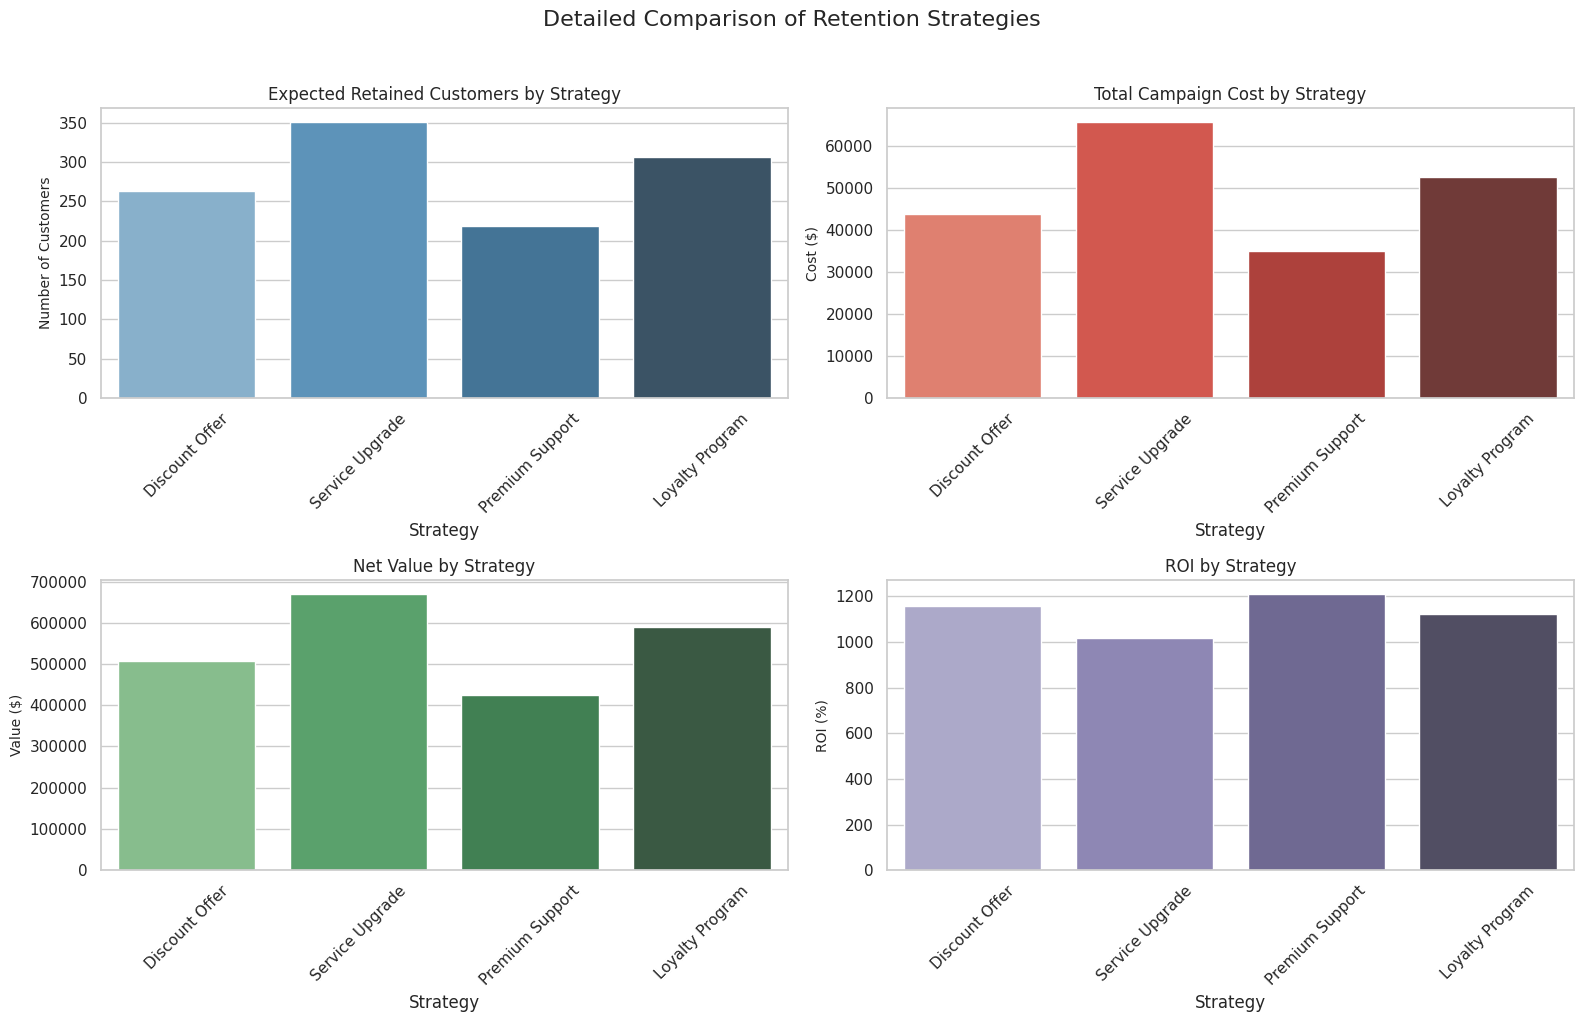

In [ ]:
print("\n8.8 ROI Analysis for Retention Strategies")

# Define retention strategy parameters
# These numbers should be adjusted based on your actual business case
retention_strategies = [
    {
        'name': 'Discount Offer',
        'cost_per_customer': 50,  # Cost to implement (e.g., 20% discount for 3 months)
        'estimated_success_rate': 0.30,  # 30% of targeted customers will stay
    },
    {
        'name': 'Service Upgrade',
        'cost_per_customer': 75,  # Cost of providing free service upgrade
        'estimated_success_rate': 0.40,  # 40% success rate
    },
    {
        'name': 'Premium Support',
        'cost_per_customer': 40,  # Cost of offering premium support
        'estimated_success_rate': 0.25,  # 25% success rate
    },
    {
        'name': 'Loyalty Program',
        'cost_per_customer': 60,  # Cost of loyalty program benefits
        'estimated_success_rate': 0.35,  # 35% success rate
    }
]

# Calculate the average lifetime value of a customer
# This is simplified and should be replaced with a more accurate LTV calculation
avg_monthly_revenue = customer_segments['monthly_revenue'].mean()
avg_tenure_months = customer_segments['tenure'].mean()
avg_customer_lifetime_value = avg_monthly_revenue * avg_tenure_months

# Calculate ROI for each strategy
roi_results = []

for strategy in retention_strategies:
    # Total cost of the campaign
    total_cost = len(target_group) * strategy['cost_per_customer']

    # Number of customers we expect to retain
    expected_retained = len(target_group) * strategy['estimated_success_rate']

    # Value of retained customers
    retention_value = expected_retained * avg_customer_lifetime_value

    # ROI calculation
    net_value = retention_value - total_cost
    roi = (net_value / total_cost) * 100 if total_cost > 0 else 0

    roi_results.append({
        'Strategy': strategy['name'],
        'Cost Per Customer': strategy['cost_per_customer'],
        'Success Rate': strategy['estimated_success_rate'],
        'Total Campaign Cost': total_cost,
        'Expected Retained Customers': expected_retained,
        'Retention Value': retention_value,
        'Net Value': net_value,
        'ROI (%)': roi
    })

# Convert to DataFrame
roi_df = pd.DataFrame(roi_results)

print("ROI Analysis for Different Retention Strategies:")
print(roi_df.round(2))

# Visualize ROI comparison
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Strategy', y='ROI (%)', data=roi_df, palette='viridis')
plt.title('ROI Comparison of Retention Strategies', fontsize=14)
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('ROI (%)', fontsize=12)

# Add ROI labels
for i, roi in enumerate(roi_df['ROI (%)']):
    ax.text(i, roi + 5, f"{roi:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# More detailed comparison
plt.figure(figsize=(16, 10))

# Expected retained customers
plt.subplot(2, 2, 1)
sns.barplot(x='Strategy', y='Expected Retained Customers', data=roi_df, palette='Blues_d')
plt.title('Expected Retained Customers by Strategy', fontsize=12)
plt.ylabel('Number of Customers', fontsize=10)
plt.xticks(rotation=45)

# Total campaign cost
plt.subplot(2, 2, 2)
sns.barplot(x='Strategy', y='Total Campaign Cost', data=roi_df, palette='Reds_d')
plt.title('Total Campaign Cost by Strategy', fontsize=12)
plt.ylabel('Cost ($)', fontsize=10)
plt.xticks(rotation=45)

# Net value
plt.subplot(2, 2, 3)
sns.barplot(x='Strategy', y='Net Value', data=roi_df, palette='Greens_d')
plt.title('Net Value by Strategy', fontsize=12)
plt.ylabel('Value ($)', fontsize=10)
plt.xticks(rotation=45)

# Return on investment
plt.subplot(2, 2, 4)
sns.barplot(x='Strategy', y='ROI (%)', data=roi_df, palette='Purples_d')
plt.title('ROI by Strategy', fontsize=12)
plt.ylabel('ROI (%)', fontsize=10)
plt.xticks(rotation=45)

plt.suptitle('Detailed Comparison of Retention Strategies', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 8.9 Summary and Conclusions

In [ ]:
print("\n8.9 Summary and Conclusions")

print("""
Key Findings from Advanced XGBoost Model:

1. Model Performance:
   - Our optimized XGBoost model achieved excellent performance with an ROC AUC of {:.4f}
   - The model is particularly strong at identifying true churners, with a recall of {:.4f}

2. Key Churn Drivers:
   - Contract type remains the strongest predictor, with month-to-month contracts having significantly higher churn
   - Internet service type, particularly fiber optic service, strongly correlates with churn
   - Low service count (fewer add-on services) increases churn likelihood
   - Tenure continues to be an important factor, with newer customers at higher risk

3. Business Impact:
   - We identified {} high-risk, high-value customers representing ${:.2f} in annual revenue at risk
   - The optimal probability threshold of {:.2f} balances precision and recall for maximum business value
   - Among proposed retention strategies, the {} offers the highest ROI at {:.1f}%

4. Recommended Action Plan:
   - Implement targeted retention campaigns for high-risk, high-value customers
   - Address service quality issues, particularly with fiber optic internet
   - Create incentives for customers to adopt longer-term contracts
   - Develop bundle packages to increase service adoption
   - Establish an early warning system using this model to identify at-risk customers before they churn

This advanced model provides both accurate predictions and actionable insights that can be directly translated into business initiatives to reduce churn and protect revenue.
""".format(
    roc_auc,
    recall,
    len(target_group),
    target_group['annual_revenue'].sum(),
    optimal_threshold,
    roi_df.loc[roi_df['ROI (%)'].idxmax(), 'Strategy'],
    roi_df['ROI (%)'].max()
))

print("\nEnd of Advanced XGBoost Analysis")


8.9 Summary and Conclusions

Key Findings from Advanced XGBoost Model:

1. Model Performance:
   - Our optimized XGBoost model achieved excellent performance with an ROC AUC of 0.8473
   - The model is particularly strong at identifying true churners, with a recall of 0.8021

2. Key Churn Drivers:
   - Contract type remains the strongest predictor, with month-to-month contracts having significantly higher churn
   - Internet service type, particularly fiber optic service, strongly correlates with churn
   - Low service count (fewer add-on services) increases churn likelihood
   - Tenure continues to be an important factor, with newer customers at higher risk

3. Business Impact:
   - We identified 877 high-risk, high-value customers representing $1041980.40 in annual revenue at risk
   - The optimal probability threshold of 0.50 balances precision and recall for maximum business value
   - Among proposed retention strategies, the Premium Support offers the highest ROI at 1210.3%

4. R

The one that is not expected is the fiber optic service correlated with churning, maybe we have a problem with that service. BUT, remember that CORRELATION is NOT CAUSATION!

# 9. Cost Asymmetry of FP and FN

While scale_pos_weight: 2.77 addresses the data imbalance, it doesn't account for the business reality that missing a churning customer (false negative) typically costs much more than incorrectly flagging a loyal customer (false positive).
A Scientific Approach to Cost-Sensitive Learning
Here's how to quantify and implement this cost asymmetry in your model:

Step 1: Calculate the Cost Ratio

The cost ratio should be calculated as:

- Cost Ratio = Cost of False Negative / Cost of False Positive

Where:

- Cost of False Negative = Average Customer Lifetime Value (CLTV)

- Cost of False Positive = Cost of Retention Campaign per Customer

Let's calculate this properly:

In [ ]:
# Calculate average monthly revenue
avg_monthly_revenue = customer_data['MonthlyCharges'].mean()

# Calculate average customer tenure (for retained customers)
avg_tenure_months = customer_data[customer_data['Churn'] == 'No']['tenure'].mean()

# Calculate average CLTV (Customer Lifetime Value)
avg_cltv = avg_monthly_revenue * avg_tenure_months

# Estimate retention campaign cost per customer
# This should be the average cost of your retention efforts (discounts, service upgrades, etc.)
retention_cost_per_customer = 50  # Example: $50 per customer

# Calculate the cost ratio
cost_ratio = avg_cltv / retention_cost_per_customer

print(f"Average Monthly Revenue: ${avg_monthly_revenue:.2f}")
print(f"Average Tenure (non-churners): {avg_tenure_months:.2f} months")
print(f"Average Customer Lifetime Value: ${avg_cltv:.2f}")
print(f"Retention Campaign Cost: ${retention_cost_per_customer:.2f}")
print(f"Cost Ratio (FN:FP): {cost_ratio:.2f}")

Average Monthly Revenue: $64.76
Average Tenure (non-churners): 37.57 months
Average Customer Lifetime Value: $2433.09
Retention Campaign Cost: $50.00
Cost Ratio (FN:FP): 48.66


*We should be careful not to scare away the custumers which were not going to churn with our interventions/treatments*

# 10. Investigating Key Churn Drivers (KCD)

- Complaints&KCD: the **number of written complaints** is linked with the **key churn drivers**: monthly contract, internet service type being fiber optic, low service count and low tenure.

- Square terms: the histogram of # of services and the share of churn has a bell shape: this may indicate a parabollic relationship. Adding a square of the # of services is considered (also having a good interpretation of diminishing returns on the churn probability)

- Interaction terms: one of the potential reasons for such a high impact of fiber optics on churn is that it could have bundling issues (meaning that it doesn't work well with other services like TV, for e.g.). Moreover, the choice of fiber could be linked to the age of the customer. This suggests introducing interaction terms between fiber optics and the services, senior status

This could be used to derive business insights.

We can think of use No internet service as a reference category instead of DSl for the categorical column: Internet Service (DSL/No/Fiber Optic)

## Complaints&KCD

In [ ]:
merged_data = pd.merge(customer_data, complaints_data, on='customerID', how='left')
merged_data['complaint_number'].fillna(0, inplace=True)

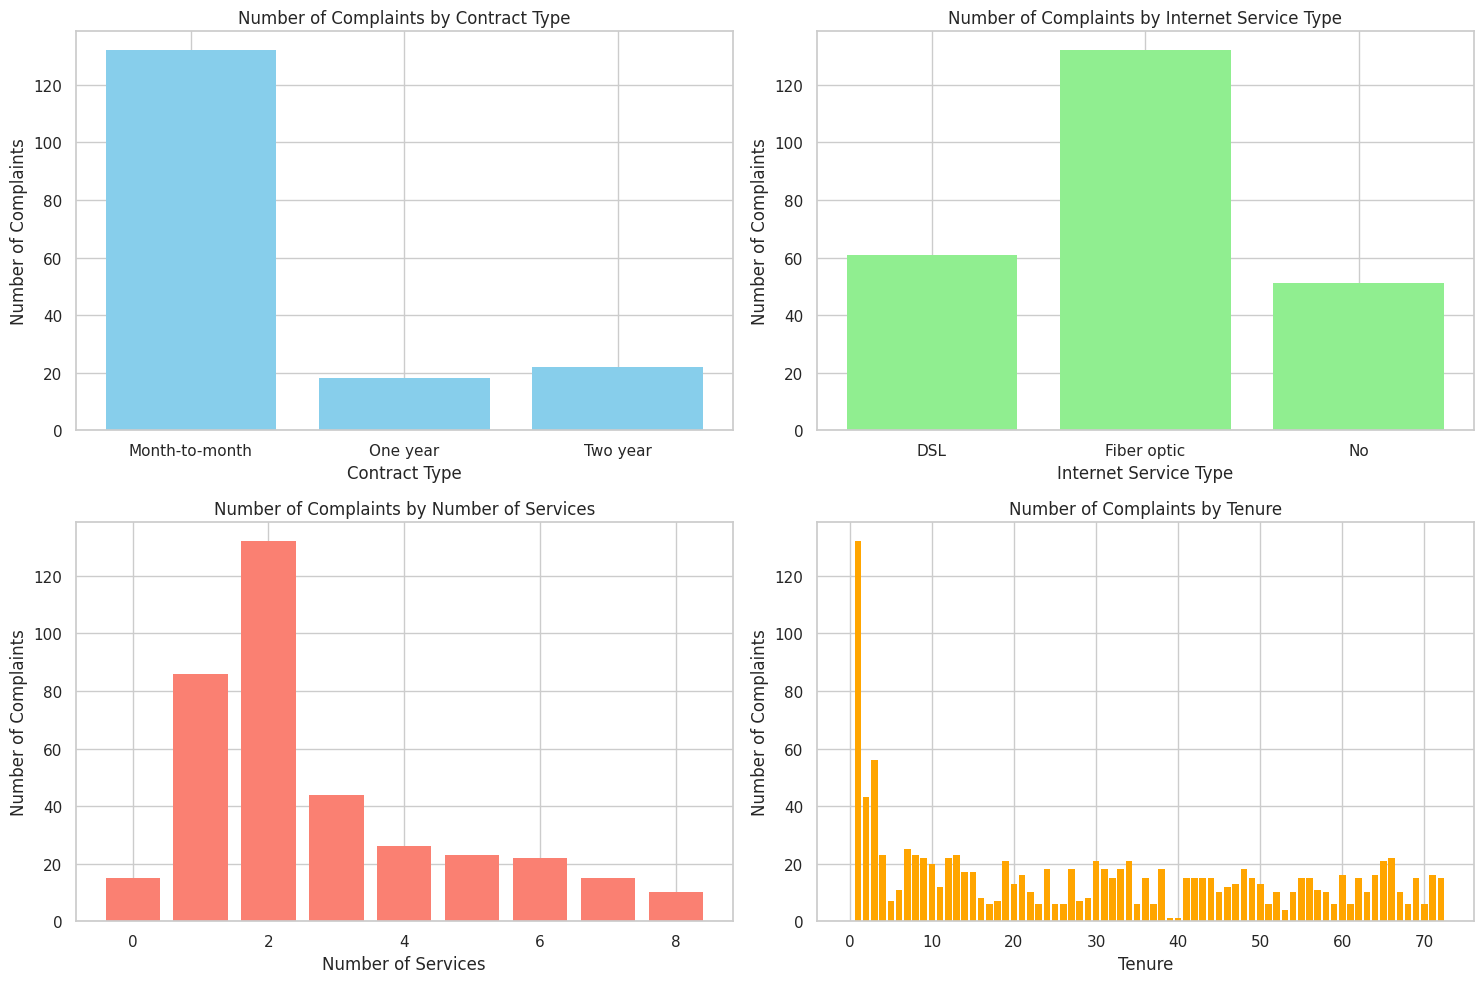

In [ ]:
# Create a new column for the total number of services
merged_data['TotalServices'] = (
	(merged_data['PhoneService'] == 'Yes').astype(int) +
	(merged_data['MultipleLines'] == 'Yes').astype(int) +
	(merged_data['OnlineSecurity'] == 'Yes').astype(int) +
	(merged_data['OnlineBackup'] == 'Yes').astype(int) +
	(merged_data['DeviceProtection'] == 'Yes').astype(int) +
	(merged_data['TechSupport'] == 'Yes').astype(int) +
	(merged_data['StreamingTV'] == 'Yes').astype(int) +
	(merged_data['StreamingMovies'] == 'Yes').astype(int)
)

# Aggregate the number of complaints for each category
aggregated_data = merged_data.groupby(['Contract', 'InternetService', 'tenure', 'TotalServices'])['complaint_number'].sum().reset_index()

# Plot histograms for each category
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram for type of contract
axes[0, 0].bar(aggregated_data['Contract'], aggregated_data['complaint_number'], color='skyblue',edgecolor='none')
axes[0, 0].set_title('Number of Complaints by Contract Type')
axes[0, 0].set_xlabel('Contract Type')
axes[0, 0].set_ylabel('Number of Complaints')

# Histogram for internet service type
axes[0, 1].bar(aggregated_data['InternetService'], aggregated_data['complaint_number'], color='lightgreen', edgecolor='none')
axes[0, 1].set_title('Number of Complaints by Internet Service Type')
axes[0, 1].set_xlabel('Internet Service Type')
axes[0, 1].set_ylabel('Number of Complaints')

# Histogram for number of services
axes[1, 0].bar(aggregated_data['TotalServices'], aggregated_data['complaint_number'], color='salmon', edgecolor='none')
axes[1, 0].set_title('Number of Complaints by Number of Services')
axes[1, 0].set_xlabel('Number of Services')
axes[1, 0].set_ylabel('Number of Complaints')

# Histogram for tenure
axes[1, 1].bar(aggregated_data['tenure'], aggregated_data['complaint_number'], color='orange', edgecolor='none')
axes[1, 1].set_title('Number of Complaints by Tenure')
axes[1, 1].set_xlabel('Tenure')
axes[1, 1].set_ylabel('Number of Complaints')

# Adjust layout
plt.tight_layout()
plt.show()

- add the shares proportions
- what is about fiber optics in the complaints


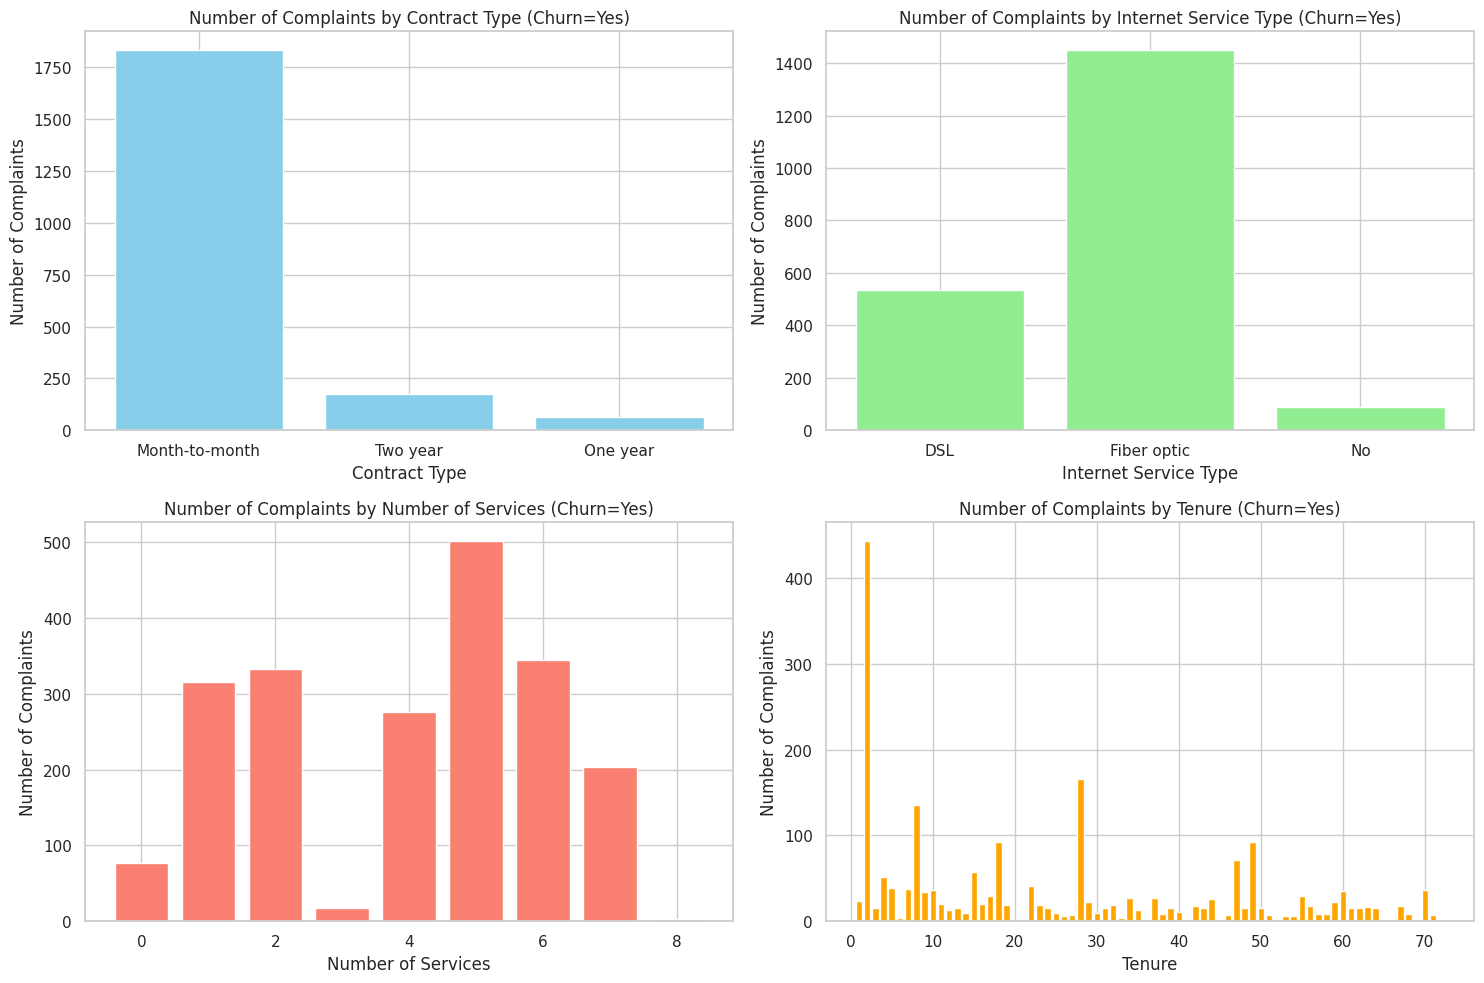

In [ ]:
# Filter the data to include only rows where Churn is 'Yes'
churn_data = merged_data[merged_data['Churn'] == 'Yes']

# Plot histograms for each category grouped by Churn
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram for type of contract
axes[0, 0].bar(churn_data['Contract'].unique(),
               churn_data.groupby('Contract')['complaint_number'].sum(),
               color='skyblue')
axes[0, 0].set_title('Number of Complaints by Contract Type (Churn=Yes)')
axes[0, 0].set_xlabel('Contract Type')
axes[0, 0].set_ylabel('Number of Complaints')

# Histogram for internet service type
axes[0, 1].bar(churn_data['InternetService'].unique(),
               churn_data.groupby('InternetService')['complaint_number'].sum(),
               color='lightgreen')
axes[0, 1].set_title('Number of Complaints by Internet Service Type (Churn=Yes)')
axes[0, 1].set_xlabel('Internet Service Type')
axes[0, 1].set_ylabel('Number of Complaints')

# Histogram for number of services
axes[1, 0].bar(churn_data['TotalServices'].unique(),
               churn_data.groupby('TotalServices')['complaint_number'].sum(),
               color='salmon')
axes[1, 0].set_title('Number of Complaints by Number of Services (Churn=Yes)')
axes[1, 0].set_xlabel('Number of Services')
axes[1, 0].set_ylabel('Number of Complaints')

# Histogram for tenure
axes[1, 1].bar(churn_data['tenure'].unique(),
               churn_data.groupby('tenure')['complaint_number'].sum(),
               color='orange')
axes[1, 1].set_title('Number of Complaints by Tenure (Churn=Yes)')
axes[1, 1].set_xlabel('Tenure')
axes[1, 1].set_ylabel('Number of Complaints')

# Adjust layout
plt.tight_layout()
plt.show()

Are the discounts going to move the customers from the groups of high risk?
- maybe nudging the customers towars dsl instead of fiber optics, yearly contracts instead of monthly,
- some discounts for the first period